# 1.2. Load and Processs Data

In [ ]:
# Installing required packages
!pip install transformers
!pip install -q sentencepiece
!pip install sentencepiece

# Importing necessary libraries
import re
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from transformers import BertModel, BertConfig, BertTokenizer, AdamW

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Clone the PQuAD dataset from GitHub
!git clone https://github.com/AUT-NLP/PQuAD.git

# Load the PQuad dataset
train_file_path = '/content/PQuAD/Dataset/Train.json'
test_file_path = '/content/PQuAD/Dataset/Test.json'
val_file_path = '/content/PQuAD/Dataset/Validation.json'

Cloning into 'PQuAD'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 9), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), 5.71 MiB | 2.88 MiB/s, done.


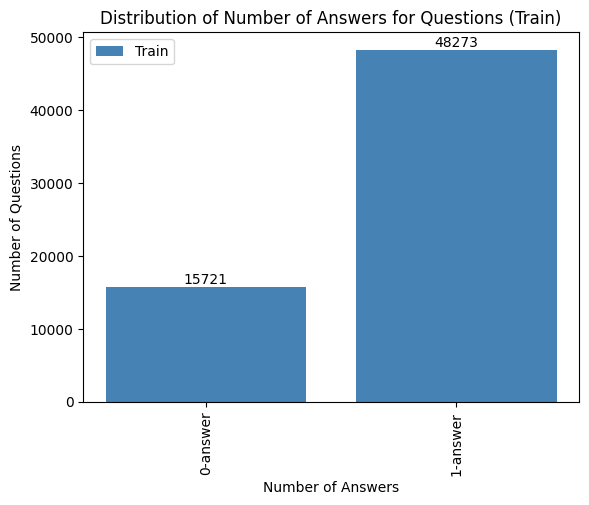

Dataset Statistics (Train):
Total Questions: 8979
Total Unanswerable Questions: 15721
Mean # of Paragraph Tokens: 919.56
Mean # of Question Tokens: 73.69
Mean # of Answer Tokens: 28.06



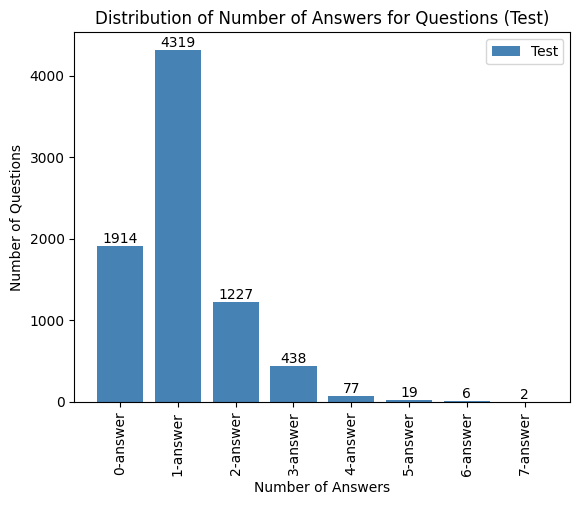

Dataset Statistics (Test):
Total Questions: 1059
Total Unanswerable Questions: 1914
Mean # of Paragraph Tokens: 968.15
Mean # of Question Tokens: 81.91
Mean # of Answer Tokens: 41.80



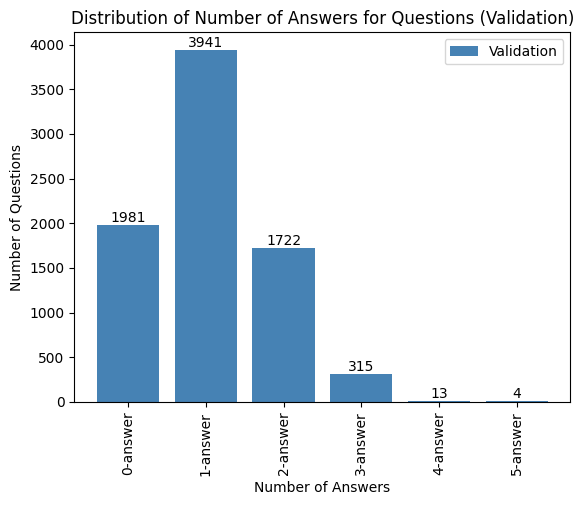

Dataset Statistics (Validation):
Total Questions: 1103
Total Unanswerable Questions: 1981
Mean # of Paragraph Tokens: 905.68
Mean # of Question Tokens: 76.47
Mean # of Answer Tokens: 42.83



In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Path to the dataset files
train_file_path = '/content/PQuAD/Dataset/Train.json'
test_file_path = '/content/PQuAD/Dataset/Test.json'
val_file_path = '/content/PQuAD/Dataset/Validation.json'

def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = json.load(file)
    return dataset

def plot_answer_distribution(dataset, dataset_name, file_name):
    num_answers = []
    for data in dataset['data']:
        for paragraph in data['paragraphs']:
            for qa in paragraph['qas']:
                num_answers.append(len(qa['answers']))

    bins = np.arange(max(num_answers) + 2)
    hist, edges = np.histogram(num_answers, bins=bins)

    fig, ax = plt.subplots()
    ax.bar(edges[:-1], hist, width=0.8, align='center', color='steelblue')

    # Add count labels in the middle and above each bar
    for i, count in enumerate(hist):
        if count > 0:
            ax.text(edges[i], count + 1, str(int(count)), ha='center', va='bottom')

    plt.xlabel('Number of Answers')
    plt.ylabel('Number of Questions')
    plt.title(f'Distribution of Number of Answers for Questions ({dataset_name})')
    plt.xticks(np.arange(max(num_answers) + 1), [f'{i}-answer' for i in range(max(num_answers) + 1)], rotation=90)
    plt.legend([dataset_name])
    plt.savefig(file_name, format='pdf', bbox_inches='tight')
    plt.show()

def print_dataset_statistics(dataset, dataset_name):
    total_questions = 0
    total_unanswerable_questions = 0
    total_paragraph_tokens = 0
    total_question_tokens = 0
    total_answer_tokens = 0

    for data in dataset['data']:
        total_questions += len(data['paragraphs'])
        for paragraph in data['paragraphs']:
            for qa in paragraph['qas']:
                if qa['is_impossible']:
                    total_unanswerable_questions += 1
                total_paragraph_tokens += len(paragraph['context'].split())
                total_question_tokens += len(qa['question'].split())
                total_answer_tokens += sum([len(answer['text'].split()) for answer in qa['answers']])

    mean_paragraph_tokens = total_paragraph_tokens / total_questions
    mean_question_tokens = total_question_tokens / total_questions
    mean_answer_tokens = total_answer_tokens / total_questions

    print(f"Dataset Statistics ({dataset_name}):")
    print(f"Total Questions: {total_questions}")
    print(f"Total Unanswerable Questions: {total_unanswerable_questions}")
    print(f"Mean # of Paragraph Tokens: {mean_paragraph_tokens:.2f}")
    print(f"Mean # of Question Tokens: {mean_question_tokens:.2f}")
    print(f"Mean # of Answer Tokens: {mean_answer_tokens:.2f}")
    print()

# Load the train dataset
train_dataset = load_dataset(train_file_path)

# Plot the distribution of the number of answers for train questions and save as PDF
plot_answer_distribution(train_dataset, 'Train', 'traindistribution.pdf')

# Print the statistical information of the train dataset
print_dataset_statistics(train_dataset, 'Train')

# Load the test dataset
test_dataset = load_dataset(test_file_path)

# Plot the distribution of the number of answers for test questions and save as PDF
plot_answer_distribution(test_dataset, 'Test', 'testdistribution.pdf')

# Print the statistical information of the test dataset
print_dataset_statistics(test_dataset, 'Test')

# Load the validation dataset
val_dataset = load_dataset(val_file_path)

# Plot the distribution of the number of answers for validation questions and save as PDF
plot_answer_distribution(val_dataset, 'Validation', 'validationdistribution.pdf')

# Print the statistical information of the validation dataset
print_dataset_statistics(val_dataset, 'Validation')


In [ ]:
# Set the minimum and maximum length for data
min_len, max_len = 128, 256

# Set the value of N
N = 3

In [ ]:
def json_to_dataframe(file):
    # Open the JSON file
    f = open(file, "r")
    data = json.loads(f.read())  # Load the JSON file

    # Create empty lists to store values
    ids = []
    titles = []
    contexts = []
    questions = []
    ans_starts = []
    texts = []

    # Iterate over the JSON data
    for i in range(len(data['data'])):
        title = data['data'][i]['title']  # Extract the 'title' value

        # Iterate over the paragraphs in the JSON data
        for p in range(len(data['data'][i]['paragraphs'])):
            context = data['data'][i]['paragraphs'][p]['context']  # Extract the 'context' value

            # Iterate over the questions in the JSON data
            for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):
                question = data['data'][i]['paragraphs'][p]['qas'][q]['question']  # Extract the 'question' value
                qid = data['data'][i]['paragraphs'][p]['qas'][q]['id']  # Extract the 'id' value

                # Check if the question has answers
                if len(data['data'][i]['paragraphs'][p]['qas'][q]['answers']) == 0:
                    ans_start = -1
                    text = ''

                    # Append the values to the lists
                    titles.append(title)
                    contexts.append(context)
                    questions.append(question)
                    ids.append(qid)
                    ans_starts.append(ans_start)
                    texts.append(text)
                else:
                    # Iterate over the answers in the JSON data
                    for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])):
                        ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']  # Extract the 'answer_start' value
                        text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']  # Extract the 'text' value

                        # Append the values to the lists
                        titles.append(title)
                        contexts.append(context)
                        questions.append(question)
                        ids.append(qid)
                        ans_starts.append(ans_start)
                        texts.append(text)

    # Create an empty DataFrame
    new_df = pd.DataFrame(columns=['Id', 'title', 'context', 'question', 'ans_start', 'text'])

    # Set the values of the DataFrame columns
    new_df['Id'] = ids
    new_df['title'] = titles
    new_df['context'] = contexts
    new_df['question'] = questions
    new_df['ans_start'] = ans_starts
    new_df['text'] = texts

    # Drop duplicate rows from the DataFrame
    final_df = new_df.drop_duplicates(keep='first')

    return final_df


# Convert the train JSON file to a DataFrame
df_train = json_to_dataframe(train_file_path)

# Get the number of rows in the train DataFrame
train_rows = df_train.shape[0]
print('Size of the train DataFrame before concatenation is {}'.format(train_rows))

# Convert the test JSON file to a DataFrame
df_test = json_to_dataframe(test_file_path)

# Convert the validation JSON file to a DataFrame
df_validation = json_to_dataframe(val_file_path)

# Concatenate the train and validation DataFrames
# frames = [df_train, df_validation]
# df_train = pd.concat(frames)

# Get the number of rows in the concatenated train DataFrame
train_rows = df_train.shape[0]
print('Size of the train DataFrame after concatenation is {}'.format(train_rows))

# Display the first few rows of the train DataFrame
df_train.head()


Size of the train DataFrame before concatenation is 63994
Size of the train DataFrame after concatenation is 63994


,Id,title,context,question,ans_start,text
0,101001,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,موقعیت جغرافی باشگاه فوتبال آرسنال را بگویید؟,86,شمال شهر لندن
1,101002,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,لیگ برتر انگلستان موفق به کسب چند عنوان قهرمان...,173,۱۴
2,101003,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,بیشترین بازی بدون باخت پیاپی متعلق به کدام باش...,61,باشگاه فوتبال انگلیسی
3,101004,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال موفق به کسب چند عنوان قهر...,119,۱۳
4,101005,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال چند عنوان قهرمانی در جام ...,214,۱۶


In [ ]:
def add_end_index(answers_text, answers_start, contexts):
    new_answers = []

    # Loop through each answer-context pair
    for answer_text, answer_start, context in tqdm(zip(answers_text, answers_start, contexts)):
        start_shift = 0

        # Remove start half-spaces from the answer text
        text = re.sub("^\u200c", "", answer_text)
        
        # Check if the length of the text is one less than the length of the original answer
        if len(list(text)) == (len(list(answer_text)) - 1):
            start_shift += 1
        
        # Remove end half-spaces from the text
        text = re.sub("\u200c$", "", text)
        
        # Remove leading and trailing whitespaces from the text
        text = re.sub("^\s+", '', text)
        text = re.sub("\s+$", '', text)

        # Adjust the answer_start index by the start_shift value
        answer_start += start_shift
        
        # Calculate the end index of the answer
        end_idx = answer_start + len(text)

        # Check if the answer is correct
        if context[answer_start:end_idx] == text:
            # If the answer is correct, set the answer_end index to end_idx
            answer_end = end_idx
        else:
            # If the answer is off by 1-2 tokens, adjust the answer_start and answer_end indices
            for n in [1, 2]:
                if context[answer_start - n:end_idx - n] == text:
                    answer_start = answer_start - n
                    answer_end = end_idx - n

        # Append the modified answer to the new_answers list
        new_answers.append({'text': text, 'answer_start': answer_start, 'answer_end': answer_end})

    return new_answers


In [ ]:
def prepare_data(dataset):
    # Extract necessary columns from the dataset
    answer_start = dataset['ans_start'].tolist()
    text = dataset['text'].tolist()
    questions = dataset['question'].tolist()
    contexts = dataset['context'].tolist()

    # Call the add_end_index function to process answers
    answers = add_end_index(text, answer_start, contexts)

    # Return a dictionary with the prepared data
    return {
        'question': questions,
        'context': contexts,
        'answers': answers
    }


In [ ]:
# Prepare the training dataset
train_dataset = prepare_data(df_train)

# Prepare the validation dataset
val_dataset = prepare_data(df_validation)

# Prepare the test dataset
test_dataset = prepare_data(df_test)

# Access the second answer in the training dataset
answer = train_dataset['answers'][10]
train_dataset['answers'][10]

63994it [00:00, 148179.51it/s]
10379it [00:00, 134221.35it/s]
10417it [00:00, 115438.75it/s]


{'text': 'پنج عنوان قهرمانی در چمپیونشیپ و دو قهرمانی در جام حذفی',
 'answer_start': 288,
 'answer_end': 343}

# 1.3. ParsBERT (Data Processing and Training)

In [ ]:
# Specify the model name or path
model_name_or_path = 'HooshvareLab/bert-base-parsbert-uncased'

# Create a tokenizer instance from the specified model
tokenizer = BertTokenizer.from_pretrained(model_name_or_path)


In [ ]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(train_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(train_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(train_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(train_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens: 1 for [CLS] and 2 for [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(train_dataset['context'][i])
            new_question.append(train_dataset['question'][i])
            new_answer.append({
                'text': train_dataset['answers'][i]['text'],
                'answer_start': train_dataset['answers'][i]['answer_start'],
                'answer_end': train_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new training dataset with the filtered data
new_train_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 63994
Number of data without [UNK] and containing 128-256 tokens is 51797
Percentage of data without [UNK] and containing 128-256 tokens is 80.94040066256211


In [ ]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(val_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(val_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(val_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(val_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens, [CLS] and 2 [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(val_dataset['context'][i])
            new_question.append(val_dataset['question'][i])
            new_answer.append({
                'text': val_dataset['answers'][i]['text'],
                'answer_start': val_dataset['answers'][i]['answer_start'],
                'answer_end': val_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new validation dataset with the filtered data
new_val_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 10379
Number of data without [UNK] and containing 128-256 tokens is 8258
Percentage of data without [UNK] and containing 128-256 tokens is 79.56450525098757


In [ ]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(test_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(test_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(test_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(test_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens, [CLS] and 2 [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(test_dataset['context'][i])
            new_question.append(test_dataset['question'][i])
            new_answer.append({
                'text': test_dataset['answers'][i]['text'],
                'answer_start': test_dataset['answers'][i]['answer_start'],
                'answer_end': test_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new validation dataset with the filtered data
new_test_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 10417
Number of data without [UNK] and containing 128-256 tokens is 8367
Percentage of data without [UNK] and containing 128-256 tokens is 80.32062973984833


In [ ]:
# Create a DataFrame for the test dataset
test_df = pd.DataFrame.from_dict(new_test_dataset)

# Create a DataFrame for the validation dataset
validation_df = pd.DataFrame.from_dict(new_val_dataset)

# Create a DataFrame for the training dataset
train_df = pd.DataFrame.from_dict(new_train_dataset)

In [ ]:
# Print the length of the training dataset
print("Length of the training dataset: {}".format(len(train_df)))

# Display the first few rows of the training dataset
print("Training dataset:")
train_df.head()

Length of the training dataset: 51797
Training dataset:


,question,context,answers
0,لیگ برتر انگلستان موفق به کسب چند عنوان قهرمان...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۴', 'answer_start': 173, 'answer_en..."
1,بیشترین بازی بدون باخت پیاپی متعلق به کدام باش...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': 'باشگاه فوتبال انگلیسی', 'answer_star..."
2,باشگاه فوتبال آرسنال موفق به کسب چند عنوان قهر...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۳', 'answer_start': 119, 'answer_en..."
3,باشگاه فوتبال آرسنال چند عنوان قهرمانی در جام ...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۶', 'answer_start': 214, 'answer_en..."
4,باشگاه فوتبال آرسنال چند قهرمانی در جام اتحادی...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': 'دو قهرمانی', 'answer_start': 249, 'a..."


In [ ]:
# Print the length of the validation dataset
print("Length of the validation dataset: {}".format(len(validation_df)))

# Display the first few rows of the validation dataset
print("Validation dataset:")
validation_df.head()

Length of the validation dataset: 8258
Validation dataset:


,question,context,answers
0,آژانس بین‌المللی انرژی اتمی برای حفاظت از بازی...,با توجه به خشونت‌های اخیری که در ریودوژانیرو و...,{'text': 'برای جلوگیری از وقوع حملات تروریستی ...
1,آژانس بین‌المللی انرژی اتمی برای حفاظت از بازی...,با توجه به خشونت‌های اخیری که در ریودوژانیرو و...,{'text': 'امکانات لازم را در اختیار این کشور ق...
2,چرا آژانس بین‌المللی انرژی اتمی امکانات لازم ر...,با توجه به خشونت‌های اخیری که در ریودوژانیرو و...,{'text': 'برای جلوگیری از وقوع حملات تروریستی ...
3,چرا آژانس بین‌المللی انرژی اتمی امکانات لازم ر...,با توجه به خشونت‌های اخیری که در ریودوژانیرو و...,{'text': 'برای جلوگیری از وقوع حملات تروریستی ...
4,طبق آمار اوایل ماه دسامبر 2015 چند نفر به تب د...,مشکل دیگر برزیل مقابله با پشه‌ها و برخی بیماری...,"{'text': '۱٫۵۸ میلیون نفر', 'answer_start': 10..."


In [ ]:
# Print the length of the test dataset
print("Length of the test dataset: {}".format(len(test_df)))

# Display the first few rows of the test dataset
print("Test dataset:")
test_df.head()

Length of the test dataset: 8367
Test dataset:


,question,context,answers
0,چند اسم از اسماء قرآن در خود قرآن آمده‌است؟,به نوشته محمد صادقی تهرانی، اسامی قرآن، از جم...,"{'text': 'حدود چهل اسم', 'answer_start': 582, ..."
1,چند اسم از اسماء قرآن در خود قرآن آمده‌است؟,به نوشته محمد صادقی تهرانی، اسامی قرآن، از جم...,"{'text': 'حدود چهل اسم در قرآن آمده', 'answe..."
2,چند اسم از اسماء قرآن در خود قرآن آمده‌است؟,به نوشته محمد صادقی تهرانی، اسامی قرآن، از جم...,"{'text': 'چهل اسم', 'answer_start': 587, 'answ..."
3,از جمله امتیازات قرآن چیست؟,به نوشته محمد صادقی تهرانی، اسامی قرآن، از جم...,{'text': 'این است که چه اسم‌های خود قرآن و چه...
4,از جمله امتیازات قرآن چیست؟,به نوشته محمد صادقی تهرانی، اسامی قرآن، از جم...,{'text': 'چه اسم‌های خود قرآن و چه اسم‌هایی ک...


In [ ]:
def prepare_data_2(dataset):
    # Extract the questions, contexts, and answers from the dataset
    questions = dataset['question'].tolist()
    contexts = dataset['context'].tolist()
    answers = dataset['answers'].tolist()
    
    # Return a dictionary containing the prepared data
    return {
        'question': questions,
        'context': contexts,
        'answers': answers
    }

# Prepare the training dataset
train_dataset = prepare_data_2(train_df)

# Prepare the validation dataset
val_dataset = prepare_data_2(validation_df)

# Prepare the test dataset
test_dataset = prepare_data_2(test_df)

In [ ]:
# Tokenize the training data using the tokenizer
train_data = tokenizer(train_dataset['context'], train_dataset['question'],
                       truncation=False, padding='max_length',
                       max_length=max_len, return_tensors='pt')

# Tokenize the validation data using the tokenizer
validation_data = tokenizer(val_dataset['context'], val_dataset['question'],
                            truncation=False, padding='max_length',
                            max_length=max_len, return_tensors='pt')

# Tokenize the test data using the tokenizer
test_data = tokenizer(test_dataset['context'], test_dataset['question'],
                            truncation=False, padding='max_length',
                            max_length=max_len, return_tensors='pt')

In [ ]:
# Function to convert character index to token index
def char_idx_to_token_idx(tokenizer, char_idx, sentence):
    # Create a list of binary values indicating whether each character is a space or a half-space
    char = [0 if sentence[i] == ' ' or sentence[i] == '‌' else 1 for i in range(len(sentence))]
    tokens = tokenizer.tokenize(sentence)
    index = char_idx

    # Adjust the index to consider half-spaces
    for i in range(index):
        if char[i] != 1:
            index -= 1

    counter = 0
    flag_continue = True
    token_index = 0

    # Find the token index corresponding to the character index
    for i in range(len(tokens)):
        if tokens[i].startswith('##'):
            tokens[i] = tokens[i][2:]
        for j in range(len(tokens[i])):
            counter += 1
            if counter == index:
                flag_continue = False
                token_index = i
                break
        if not flag_continue:
            break
    
    return token_index             

# Function to add token positions for answer start and end
def add_token_positions(tokenizer, encodings, answers, contexts):
    target_start_list = []
    target_end_list = []
    for i in tqdm(range(len(answers))):
        target_start = [0] * max_len
        target_end = [0] * max_len
        start_idx = answers[i]['answer_start']
        end_idx = answers[i]['answer_end']
        
        if start_idx <= len(contexts[i]) and end_idx <= len(contexts[i]):
            # Answerable question
            if start_idx != -1 and end_idx != -1:
                start_token_idx = char_idx_to_token_idx(tokenizer, start_idx, contexts[i]) + 1
                end_token_idx = char_idx_to_token_idx(tokenizer, end_idx, contexts[i]) + 1
                target_start[start_token_idx] = 1
                target_end[end_token_idx] = 1
                target_start_list.append(target_start)
                target_end_list.append(target_end)

            # Unanswerable question
            else:
                target_start[0] = 1
                target_end[0] = 1
                target_start_list.append(target_start)
                target_end_list.append(target_end)
        else:
            continue
    
    # Update the encodings with the target start and end lists
    encodings.update({'targets_start': target_start_list, 'targets_end': target_end_list})

# Add token positions to the train_data encodings
add_token_positions(tokenizer, train_data, train_dataset['answers'], train_dataset['context'])

# Add token positions to the validation_data encodings
add_token_positions(tokenizer, validation_data, val_dataset['answers'], val_dataset['context'])

# Add token positions to the test_data encodings
add_token_positions(tokenizer, test_data, test_dataset['answers'], test_dataset['context'])


100%|██████████| 8367/8367 [00:35<00:00, 237.71it/s]


In [ ]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        """
        Initialize the CustomDataset.

        Args:
            data (dict): The data dictionary containing input tensors.
        """
        self.data = data

    def __getitem__(self, idx):
        """
        Get an item from the dataset.

        Args:
            idx (int): The index of the item.

        Returns:
            dict: A dictionary containing input tensors.
        """
        return {key: torch.tensor(val[idx]) for key, val in self.data.items()}
    
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.data['input_ids'])


In [ ]:
# Create a custom dataset for training
train_datas = CustomDataset(train_data)
print("Length of training dataset: {}".format(len(train_datas)))

# Create a data loader for training
train_loader = torch.utils.data.DataLoader(train_datas, batch_size=32, shuffle=True)

# Create a custom dataset for validation
validation_datas = CustomDataset(validation_data)
print("Length of validation dataset: {}".format(len(validation_datas)))

# Create a data loader for validation
validation_loader = torch.utils.data.DataLoader(validation_datas, batch_size=32, shuffle=False)

# Create a custom dataset for test
test_datas = CustomDataset(test_data)
print("Length of test dataset: {}".format(len(test_datas)))

# Create a data loader for test
test_loader = torch.utils.data.DataLoader(test_datas, batch_size=32, shuffle=False)


Length of training dataset: 51797
Length of validation dataset: 8258
Length of test dataset: 8367


In [ ]:
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-base-parsbert-uncased'

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()

        # Initialize the BERT model
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        # Add a linear layer for classification
        self.classifier = nn.Linear(768, 2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        # Pass the input through the BERT model
        sequence_output, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        # Apply linear layer to the BERT output
        # Shape: (batch_size, num_tokens, 768)
        logits = self.classifier(sequence_output)
        # Shape: (batch_size, num_tokens, 2)
        
        # Split the logits into start and end logits
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # Shape: (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits


In [ ]:
def loss_fn(start_logits, end_logits, start_targets, end_targets):
    """
    Compute the loss function given the predicted start and end logits and the target start and end positions.

    Args:
        start_logits (torch.Tensor): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (torch.Tensor): Predicted end logits of shape (batch_size, num_tokens).
        start_targets (torch.Tensor): Target start positions of shape (batch_size, num_tokens).
        end_targets (torch.Tensor): Target end positions of shape (batch_size, num_tokens).

    Returns:
        torch.Tensor: Loss value.
    """
    # Compute the binary cross-entropy loss for start and end logits
    start_loss = nn.BCEWithLogitsLoss()(start_logits, start_targets.float())
    end_loss = nn.BCEWithLogitsLoss()(end_logits, end_targets.float())

    # Return the sum of the two losses
    return start_loss + end_loss

def evaluate_f1(start_pred, start_target, end_pred, end_target):
    """
    Compute the F1 score given the predicted start and end positions and the target start and end positions.

    Args:
        start_pred (int): Predicted start position.
        start_target (int): Target start position.
        end_pred (int): Predicted end position.
        end_target (int): Target end position.

    Returns:
        float: F1 score.
    """
    # Generate arrays of tokens for prediction and target spans
    pred = np.arange(start_pred, end_pred + 1)
    tar = np.arange(start_target, end_target + 1)

    # Compute the number of tokens shared between prediction and target
    tp_list = list(set.intersection(*map(set, [pred, tar])))

    # Compute the number of tokens in prediction not in target
    fp_list = list(set(pred).symmetric_difference(set(tp_list)))

    # Compute the number of tokens in target not in prediction
    fn_list = list(set(tar).symmetric_difference(set(tp_list)))

    tp, fp, fn = len(tp_list), len(fp_list), len(fn_list)

    # Compute precision, recall, and F1 score
    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if (precision + recall) != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0

    return f1


def generate_indexes(start_logits, end_logits, N, max_index_list):
    """
    Generate the start and end indexes for the predicted spans.

    Args:
        start_logits (numpy.ndarray): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (numpy.ndarray): Predicted end logits of shape (batch_size, num_tokens).
        N (int): Number of top start and end indexes to consider.
        max_index_list (list): List of maximum indexes for each example.

    Returns:
        tuple: Final start and end indexes for the predicted spans.
    """
    output_start = start_logits
    output_end = end_logits
    dimension = output_start.shape[1]

    list_start, list_end = [], []
    for n in range(output_start.shape[0]):
        start_indexes = np.arange(output_start.shape[1])
        start_probs = output_start[n]
        list_start.append(dict(zip(start_indexes, start_probs)))

        end_indexes = np.arange(output_start.shape[1])
        end_probs = output_end[n]
        list_end.append(dict(zip(end_indexes, end_probs)))

    sorted_start_list, sorted_end_list = [], []
    for j in range(len(list_start)):
        sort_start_probs = sorted(list_start[j].items(), key=lambda x: x[1], reverse=True)
        sort_end_probs = sorted(list_end[j].items(), key=lambda x: x[1], reverse=True)
        sorted_start_list.append(sort_start_probs)
        sorted_end_list.append(sort_end_probs)

    final_start_idx, final_end_idx = [], []

    for c in range(len(list_start)):
        start_idx, end_idx, prob = 0, 0, 0
        for a in range(N):
            for b in range(N):
                if (sorted_start_list[c][a][1] + sorted_end_list[c][b][1]) > prob:
                    if (sorted_start_list[c][a][0] <= sorted_end_list[c][b][0]) and (
                            sorted_end_list[c][b][0] < max_index_list[c]):
                        prob = sorted_start_list[c][a][1] + sorted_end_list[c][b][1]
                        start_idx = sorted_start_list[c][a][0]
                        end_idx = sorted_end_list[c][b][0]
        final_start_idx.append(start_idx)
        final_end_idx.append(end_idx)

    return final_start_idx, final_end_idx


def evaluate_model(start_logits, end_logits, N, max_index_list, target_start, target_end):
    """
    Evaluate the model by computing the F1 score.

    Args:
        start_logits (numpy.ndarray): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (numpy.ndarray): Predicted end logits of shape (batch_size, num_tokens).
        N (int): Number of top start and end indexes to consider.
        max_index_list (list): List of maximum indexes for each example.
        target_start (list): List of target start positions.
        target_end (list): List of target end positions.

    Returns:
        float: Mean F1 score.
    """
    final_start_idx, final_end_idx = generate_indexes(start_logits, end_logits, N, max_index_list)
    f1 = []
    for i in range(len(final_start_idx)):
        f1.append(evaluate_f1(final_start_idx[i], target_start[i], final_end_idx[i], target_end[i]))

    return np.mean(f1)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Clear GPU cache
torch.cuda.empty_cache()

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create an instance of the QAModel
qa_model = QAModel()
qa_model.to(device)  # Move the model to the appropriate device
qa_model.train()  # Set the model in training mode

# Create an instance of the AdamW optimizer with a learning rate of 5e-5
optimizer = AdamW(qa_model.parameters(), lr=5e-5)


Device: cuda:0


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-base-parsbert-uncased'

from transformers import PreTrainedModel

class QAModel2(PreTrainedModel):
    """
    QA Model based on BERT for sequence classification.
    """

    def __init__(self, config):
        super(QAModel2, self).__init__(config)
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        # self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Forward pass of the QA model.
        
        Args:
            input_ids (tensor): Input tensor of shape (batch_size, sequence_length).
            attention_mask (tensor): Attention mask tensor of shape (batch_size, sequence_length).
            token_type_ids (tensor): Token type IDs tensor of shape (batch_size, sequence_length).
        
        Returns:
            start_logits (tensor): Start logits tensor of shape (batch_size, sequence_length).
            end_logits (tensor): End logits tensor of shape (batch_size, sequence_length).
        """
        sequence_output, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Apply dropout to the sequence output
        # sequence_output = self.dropout(sequence_output)

        # (batch_size, num_tokens, 768)
        logits = self.classifier(sequence_output)
        # (batch_size, num_tokens, 2)
        
        # Split the logits into start and end logits
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits


In [ ]:
from transformers import AutoConfig, AutoTokenizer

# Clear GPU cache
torch.cuda.empty_cache()

# Determine the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the configuration for the BERT model
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Create an instance of the QAModel2 using the loaded configuration
model = QAModel2(config)

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Set the model to training mode
model.train()

# Define the optimizer
optim = AdamW(model.parameters(), lr=5e-5)


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
n_epochs = 5

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/Model1.pt')
        print('Model Saved in Google Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# # Plotting the results
# epochs = range(1, n_epochs + 1)

# # Plotting training and validation losses
# plt.figure()
# plt.plot(epochs, train_losses, label='Train')
# plt.plot(epochs, valid_losses, label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.savefig('loss_plot.pdf')
# plt.show()

# # Plotting Exact Match scores
# plt.figure()
# plt.plot(epochs, exact_match_scores)
# plt.xlabel('Epochs')
# plt.ylabel('Exact Match (%)')
# plt.title('Exact Match Score')
# plt.savefig('exact_match_plot.pdf')
# plt.show()

# # Plotting F1 scores
# plt.figure()
# plt.plot(epochs, f1_scores)
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score (%)')
# plt.title('F1 Score')
# plt.savefig('f1_score_plot.pdf')
# plt.show()


Epoch 1 - Validation: 100%|██████████| 259/259 [10:53<00:00,  2.52s/it]


Model Saved in Google Drive!
Epoch 1: Train Loss: 0.01552, Valid Loss: 0.01891, Exact Match: 32.72%, F1: 70.76%


Epoch 2 - Validation: 100%|██████████| 259/259 [10:41<00:00,  2.48s/it]


Epoch 2: Train Loss: 0.01209, Valid Loss: 0.01946, Exact Match: 34.74%, F1: 72.29%


Epoch 3 - Validation: 100%|██████████| 259/259 [10:46<00:00,  2.50s/it]


Epoch 3: Train Loss: 0.00930, Valid Loss: 0.02048, Exact Match: 34.31%, F1: 71.04%


Epoch 4 - Validation: 100%|██████████| 259/259 [10:56<00:00,  2.53s/it]


Epoch 4: Train Loss: 0.00718, Valid Loss: 0.02417, Exact Match: 34.58%, F1: 72.34%


Epoch 5 - Validation: 100%|██████████| 259/259 [10:56<00:00,  2.53s/it]

Epoch 5: Train Loss: 0.00576, Valid Loss: 0.02588, Exact Match: 33.40%, F1: 71.34%


# 1.4. ParsBERT (Evaluating)

In [ ]:
import matplotlib.pyplot as plt

# Softmax function for probability calculation
softmax = torch.nn.Softmax(dim=1)

# Set the model in evaluation mode
model.eval()

# Initialize variables for loss and evaluation metrics
n_test_batches = len(test_loader)
loss = 0
exact_match = []
f1_scores = []

# Iterate over the test data
with torch.no_grad():
    loop = tqdm(test_loader)
    for content in loop:
        # Move input tensors to the appropriate device
        input_ids = content['input_ids'].to(device)
        temp_ids = input_ids.cpu().data.numpy().tolist()
        max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [SEP]
        attention_mask = content['attention_mask'].to(device)
        token_type_ids = content['token_type_ids'].to(device)
        y_start = content['targets_start'].to(device)
        y_end = content['targets_end'].to(device)

        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        start_pred = softmax(out_start)
        end_pred = softmax(out_end)

        # Calculate the loss
        loss_batch = loss_fn(out_start, out_end, y_start, y_end)
        loss += loss_batch.item()

        # Convert labels and predictions to numpy arrays
        start_label = np.nonzero(y_start).cpu().data.numpy()
        end_label = np.nonzero(y_end).cpu().data.numpy()
        tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
        start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
        start_log = np.array(start_log)
        end_log = np.array(end_log)
        tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)

        # Calculate exact match and F1 scores
        ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0
                     for i in range(0, len(tensor_pred))]) / len(tensor_pred)
        exact_match.append(ex_ma)

        f1_score = evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(),
                                  N, max_ind, start_label[:, 1], end_label[:, 1])
        f1_scores.append(f1_score)

    # Calculate average loss and metrics
    valid_loss = loss / n_test_batches
    em_accuracy = 100 * np.mean(exact_match)
    f1_mean = 100 * np.mean(f1_scores)
    print('Test Loss: {:.4f}, Exact Match: {:.2f}%, F1 Score: {:.2f}%'.format(valid_loss, em_accuracy, f1_mean))

100%|██████████| 262/262 [10:45<00:00,  2.46s/it]

Test Loss: 0.0265, Exact Match: 34.08%, F1 Score: 71.68%


## Drafts!

In [ ]:
from transformers import AutoConfig, AutoTokenizer

# Clear GPU cache
torch.cuda.empty_cache()

# Determine the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the configuration for the BERT model
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Create an instance of the QAModel2 using the loaded configuration
model = QAModel2(config)

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Set the model to training mode
model.train()

# Define the optimizer
optim = AdamW(model.parameters(), lr=5e-6)


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
n_epochs = 5

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/Model2.pt')
        print('Model Saved in Google Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# # Plotting the results
# epochs = range(1, n_epochs + 1)

# # Plotting training and validation losses
# plt.figure()
# plt.plot(epochs, train_losses, label='Train')
# plt.plot(epochs, valid_losses, label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.savefig('loss_plot.pdf')
# plt.show()

# # Plotting Exact Match scores
# plt.figure()
# plt.plot(epochs, exact_match_scores)
# plt.xlabel('Epochs')
# plt.ylabel('Exact Match (%)')
# plt.title('Exact Match Score')
# plt.savefig('exact_match_plot.pdf')
# plt.show()

# # Plotting F1 scores
# plt.figure()
# plt.plot(epochs, f1_scores)
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score (%)')
# plt.title('F1 Score')
# plt.savefig('f1_score_plot.pdf')
# plt.show()


Epoch 1 - Validation:  73%|███████▎  | 188/259 [07:40<02:52,  2.43s/it]

In [ ]:
import matplotlib.pyplot as plt
# lr = 0.0005
# Set the number of epochs
n_epochs = 5

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/Model2.pt')
        print('Model Saved in Google Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# # Plotting the results
# epochs = range(1, n_epochs + 1)

# # Plotting training and validation losses
# plt.figure()
# plt.plot(epochs, train_losses, label='Train')
# plt.plot(epochs, valid_losses, label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.savefig('loss_plot.pdf')
# plt.show()

# # Plotting Exact Match scores
# plt.figure()
# plt.plot(epochs, exact_match_scores)
# plt.xlabel('Epochs')
# plt.ylabel('Exact Match (%)')
# plt.title('Exact Match Score')
# plt.savefig('exact_match_plot.pdf')
# plt.show()

# # Plotting F1 scores
# plt.figure()
# plt.plot(epochs, f1_scores)
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score (%)')
# plt.title('F1 Score')
# plt.savefig('f1_score_plot.pdf')
# plt.show()


Epoch 1 - Validation: 100%|██████████| 259/259 [11:17<00:00,  2.62s/it]


Model Saved in Google Drive!
Epoch 1: Train Loss: 0.06850, Valid Loss: 0.05115, Exact Match: 6.01%, F1: 9.31%


Epoch 2 - Validation: 100%|██████████| 259/259 [11:21<00:00,  2.63s/it]


Epoch 2: Train Loss: 0.05115, Valid Loss: 0.05115, Exact Match: 6.01%, F1: 9.30%


Epoch 3 - Training:  42%|████▏     | 676/1619 [14:42<20:30,  1.31s/it]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Softmax function for probability calculation
softmax = torch.nn.Softmax(dim=1)

# Set the model in evaluation mode
model.eval()

# Initialize variables for loss and evaluation metrics
n_test_batches = len(test_loader)
loss = 0
exact_match = []
f1_scores = []

# Iterate over the test data
with torch.no_grad():
    loop = tqdm(test_loader)
    for content in loop:
        # Move input tensors to the appropriate device
        input_ids = content['input_ids'].to(device)
        temp_ids = input_ids.cpu().data.numpy().tolist()
        max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [SEP]
        attention_mask = content['attention_mask'].to(device)
        token_type_ids = content['token_type_ids'].to(device)
        y_start = content['targets_start'].to(device)
        y_end = content['targets_end'].to(device)

        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        start_pred = softmax(out_start)
        end_pred = softmax(out_end)

        # Calculate the loss
        loss_batch = loss_fn(out_start, out_end, y_start, y_end)
        loss += loss_batch.item()

        # Convert labels and predictions to numpy arrays
        start_label = np.nonzero(y_start).cpu().data.numpy()
        end_label = np.nonzero(y_end).cpu().data.numpy()
        tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
        start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
        start_log = np.array(start_log)
        end_log = np.array(end_log)
        tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)

        # Calculate exact match and F1 scores
        ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0
                     for i in range(0, len(tensor_pred))]) / len(tensor_pred)
        exact_match.append(ex_ma)

        f1_score = evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(),
                                  N, max_ind, start_label[:, 1], end_label[:, 1])
        f1_scores.append(f1_score)

    # Calculate average loss and metrics
    valid_loss = loss / n_test_batches
    em_accuracy = 100 * np.mean(exact_match)
    f1_mean = 100 * np.mean(f1_scores)
    print('Test Loss: {:.4f}, Exact Match: {:.2f}%, F1 Score: {:.2f}%'.format(valid_loss, em_accuracy, f1_mean))

 71%|███████   | 186/262 [07:37<03:13,  2.55s/it]

Epoch 1 - Validation: 100%|██████████| 265/265 [11:03<00:00,  2.50s/it]


New Model Weights Saved in Drive!
Epoch 1: Train Loss: 0.02233, Valid Loss: 0.01914, Exact Match: 32.71%, F1: 70.84%


Epoch 2 - Validation: 100%|██████████| 265/265 [11:00<00:00,  2.49s/it]


New Model Weights Saved in Drive!
Epoch 2: Train Loss: 0.01456, Valid Loss: 0.01832, Exact Match: 35.02%, F1: 72.59%


Epoch 3 - Validation: 100%|██████████| 265/265 [11:06<00:00,  2.52s/it]


Epoch 3: Train Loss: 0.01107, Valid Loss: 0.01980, Exact Match: 35.06%, F1: 71.86%


Epoch 4 - Validation: 100%|██████████| 265/265 [11:12<00:00,  2.54s/it]

Epoch 4: Train Loss: 0.00854, Valid Loss: 0.02088, Exact Match: 35.49%, F1: 72.87%


TypeError: ignored

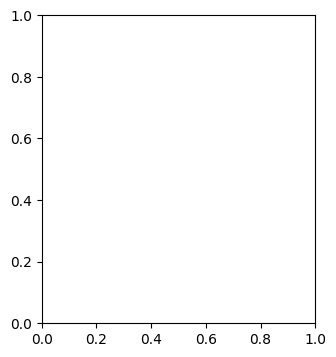

In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
n_epochs = 4

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/saved_weights4epoch_dropout_0.05.pt')
        print('New Model Weights Saved in Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# Plot the loss, EM, and F1 scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, n_epochs + 1), exact_match_scores, label='Exact Match')
plt.xlabel('Epoch')
plt.ylabel('Exact Match (%)')
plt.title('Exact Match Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, n_epochs + 1), f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (%)')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()

# Save the plot as a PDF
plt.savefig('loss_em_f1_scores.pdf', format='pdf')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
n_epochs = 10

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) for i in range(0, len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/saved_weights_dropout_0.05.pt')
        print('New Model Weights Saved in Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# Plot the loss, EM, and F1 scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, n_epochs + 1), exact_match_scores, label='Exact Match')
plt.xlabel('Epoch')
plt.ylabel('Exact Match (%)')
plt.title('Exact Match Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, n_epochs + 1), f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (%)')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()

# Save the plot as a PDF
plt.savefig('loss_em_f1_scores.pdf', format='pdf')
plt.show()


Epoch 1 - Validation: 100%|██████████| 265/265 [12:27<00:00,  2.82s/it]


New Model Weights Saved in Drive!
Epoch 1: Train Loss: 0.01479, Valid Loss: 0.01887, Exact Match: 34.88%, F1: 72.39%


Epoch 2 - Validation: 100%|██████████| 265/265 [12:13<00:00,  2.77s/it]


Epoch 2: Train Loss: 0.01128, Valid Loss: 0.01963, Exact Match: 35.76%, F1: 72.16%


Epoch 3 - Validation: 100%|██████████| 265/265 [12:17<00:00,  2.78s/it]


Epoch 3: Train Loss: 0.00879, Valid Loss: 0.02106, Exact Match: 35.81%, F1: 71.99%


Epoch 4 - Validation: 100%|██████████| 265/265 [12:14<00:00,  2.77s/it]


Epoch 4: Train Loss: 0.00692, Valid Loss: 0.02193, Exact Match: 34.21%, F1: 72.08%


Epoch 5 - Validation: 100%|██████████| 265/265 [12:20<00:00,  2.80s/it]


Epoch 5: Train Loss: 0.00566, Valid Loss: 0.02401, Exact Match: 35.33%, F1: 71.82%


Epoch 6 - Validation: 100%|██████████| 265/265 [12:29<00:00,  2.83s/it]


Epoch 6: Train Loss: 0.00480, Valid Loss: 0.02503, Exact Match: 34.44%, F1: 71.28%


Epoch 7 - Validation: 100%|██████████| 265/265 [12:32<00:00,  2.84s/it]


Epoch 7: Train Loss: 0.00405, Valid Loss: 0.02792, Exact Match: 34.52%, F1: 72.00%


Epoch 8 - Validation: 100%|██████████| 265/265 [12:22<00:00,  2.80s/it]


Epoch 8: Train Loss: 0.00361, Valid Loss: 0.02808, Exact Match: 34.05%, F1: 71.69%


Epoch 9 - Training:  44%|████▍     | 838/1889 [4:44:39<419:09:22, 1435.74s/it]

# 1.2. Load and Processs Data

In [2]:
# Installing required packages
!pip install transformers
!pip install -q sentencepiece
!pip install sentencepiece

# Importing necessary libraries
import re
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from transformers import BertModel, BertConfig, BertTokenizer, AdamW

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Clone the PQuAD dataset from GitHub
!git clone https://github.com/AUT-NLP/PQuAD.git

# Load the PQuad dataset
train_file_path = '/content/PQuAD/Dataset/Train.json'
test_file_path = '/content/PQuAD/Dataset/Test.json'
val_file_path = '/content/PQuAD/Dataset/Validation.json'

Cloning into 'PQuAD'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 9), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), 5.71 MiB | 3.59 MiB/s, done.


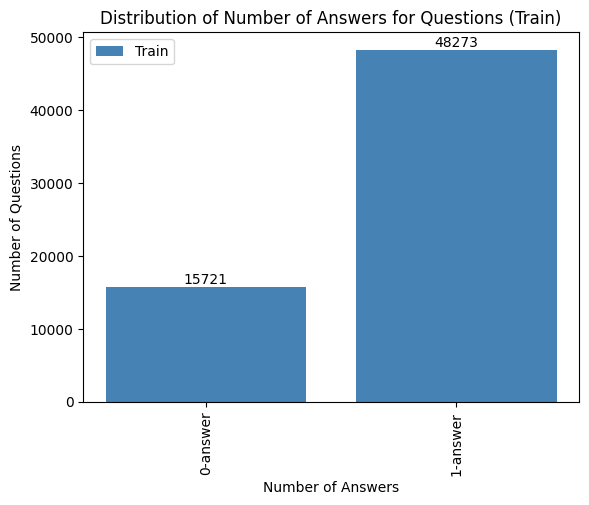

Dataset Statistics (Train):
Total Questions: 8979
Total Unanswerable Questions: 15721
Mean # of Paragraph Tokens: 919.56
Mean # of Question Tokens: 73.69
Mean # of Answer Tokens: 28.06



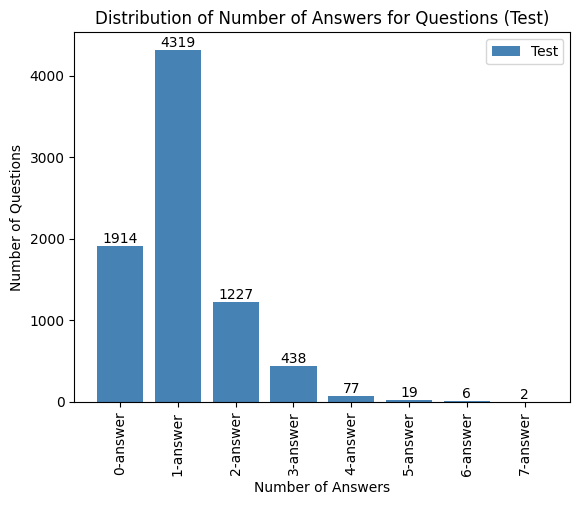

Dataset Statistics (Test):
Total Questions: 1059
Total Unanswerable Questions: 1914
Mean # of Paragraph Tokens: 968.15
Mean # of Question Tokens: 81.91
Mean # of Answer Tokens: 41.80



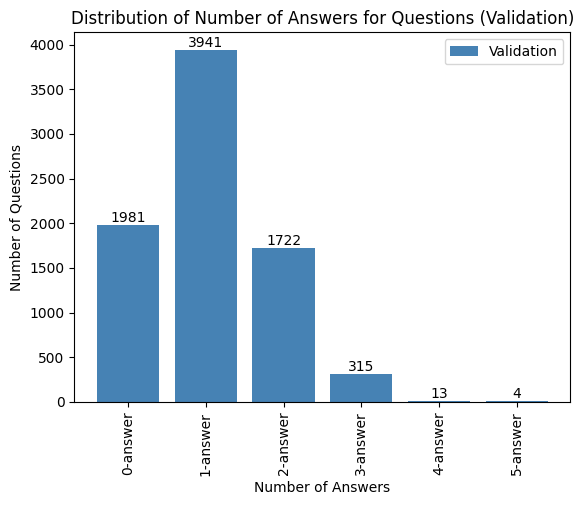

Dataset Statistics (Validation):
Total Questions: 1103
Total Unanswerable Questions: 1981
Mean # of Paragraph Tokens: 905.68
Mean # of Question Tokens: 76.47
Mean # of Answer Tokens: 42.83



In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Path to the dataset files
train_file_path = '/content/PQuAD/Dataset/Train.json'
test_file_path = '/content/PQuAD/Dataset/Test.json'
val_file_path = '/content/PQuAD/Dataset/Validation.json'

def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = json.load(file)
    return dataset

def plot_answer_distribution(dataset, dataset_name, file_name):
    num_answers = []
    for data in dataset['data']:
        for paragraph in data['paragraphs']:
            for qa in paragraph['qas']:
                num_answers.append(len(qa['answers']))

    bins = np.arange(max(num_answers) + 2)
    hist, edges = np.histogram(num_answers, bins=bins)

    fig, ax = plt.subplots()
    ax.bar(edges[:-1], hist, width=0.8, align='center', color='steelblue')

    # Add count labels in the middle and above each bar
    for i, count in enumerate(hist):
        if count > 0:
            ax.text(edges[i], count + 1, str(int(count)), ha='center', va='bottom')

    plt.xlabel('Number of Answers')
    plt.ylabel('Number of Questions')
    plt.title(f'Distribution of Number of Answers for Questions ({dataset_name})')
    plt.xticks(np.arange(max(num_answers) + 1), [f'{i}-answer' for i in range(max(num_answers) + 1)], rotation=90)
    plt.legend([dataset_name])
    plt.savefig(file_name, format='pdf', bbox_inches='tight')
    plt.show()

def print_dataset_statistics(dataset, dataset_name):
    total_questions = 0
    total_unanswerable_questions = 0
    total_paragraph_tokens = 0
    total_question_tokens = 0
    total_answer_tokens = 0

    for data in dataset['data']:
        total_questions += len(data['paragraphs'])
        for paragraph in data['paragraphs']:
            for qa in paragraph['qas']:
                if qa['is_impossible']:
                    total_unanswerable_questions += 1
                total_paragraph_tokens += len(paragraph['context'].split())
                total_question_tokens += len(qa['question'].split())
                total_answer_tokens += sum([len(answer['text'].split()) for answer in qa['answers']])

    mean_paragraph_tokens = total_paragraph_tokens / total_questions
    mean_question_tokens = total_question_tokens / total_questions
    mean_answer_tokens = total_answer_tokens / total_questions

    print(f"Dataset Statistics ({dataset_name}):")
    print(f"Total Questions: {total_questions}")
    print(f"Total Unanswerable Questions: {total_unanswerable_questions}")
    print(f"Mean # of Paragraph Tokens: {mean_paragraph_tokens:.2f}")
    print(f"Mean # of Question Tokens: {mean_question_tokens:.2f}")
    print(f"Mean # of Answer Tokens: {mean_answer_tokens:.2f}")
    print()

# Load the train dataset
train_dataset = load_dataset(train_file_path)

# Plot the distribution of the number of answers for train questions and save as PDF
plot_answer_distribution(train_dataset, 'Train', 'traindistribution.pdf')

# Print the statistical information of the train dataset
print_dataset_statistics(train_dataset, 'Train')

# Load the test dataset
test_dataset = load_dataset(test_file_path)

# Plot the distribution of the number of answers for test questions and save as PDF
plot_answer_distribution(test_dataset, 'Test', 'testdistribution.pdf')

# Print the statistical information of the test dataset
print_dataset_statistics(test_dataset, 'Test')

# Load the validation dataset
val_dataset = load_dataset(val_file_path)

# Plot the distribution of the number of answers for validation questions and save as PDF
plot_answer_distribution(val_dataset, 'Validation', 'validationdistribution.pdf')

# Print the statistical information of the validation dataset
print_dataset_statistics(val_dataset, 'Validation')


In [6]:
# Set the minimum and maximum length for data
min_len, max_len = 128, 256

# Set the value of N
N = 3

In [7]:
def json_to_dataframe(file):
    # Open the JSON file
    f = open(file, "r")
    data = json.loads(f.read())  # Load the JSON file

    # Create empty lists to store values
    ids = []
    titles = []
    contexts = []
    questions = []
    ans_starts = []
    texts = []

    # Iterate over the JSON data
    for i in range(len(data['data'])):
        title = data['data'][i]['title']  # Extract the 'title' value

        # Iterate over the paragraphs in the JSON data
        for p in range(len(data['data'][i]['paragraphs'])):
            context = data['data'][i]['paragraphs'][p]['context']  # Extract the 'context' value

            # Iterate over the questions in the JSON data
            for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):
                question = data['data'][i]['paragraphs'][p]['qas'][q]['question']  # Extract the 'question' value
                qid = data['data'][i]['paragraphs'][p]['qas'][q]['id']  # Extract the 'id' value

                # Check if the question has answers
                if len(data['data'][i]['paragraphs'][p]['qas'][q]['answers']) == 0:
                    ans_start = -1
                    text = ''

                    # Append the values to the lists
                    titles.append(title)
                    contexts.append(context)
                    questions.append(question)
                    ids.append(qid)
                    ans_starts.append(ans_start)
                    texts.append(text)
                else:
                    # Iterate over the answers in the JSON data
                    for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])):
                        ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']  # Extract the 'answer_start' value
                        text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']  # Extract the 'text' value

                        # Append the values to the lists
                        titles.append(title)
                        contexts.append(context)
                        questions.append(question)
                        ids.append(qid)
                        ans_starts.append(ans_start)
                        texts.append(text)

    # Create an empty DataFrame
    new_df = pd.DataFrame(columns=['Id', 'title', 'context', 'question', 'ans_start', 'text'])

    # Set the values of the DataFrame columns
    new_df['Id'] = ids
    new_df['title'] = titles
    new_df['context'] = contexts
    new_df['question'] = questions
    new_df['ans_start'] = ans_starts
    new_df['text'] = texts

    # Drop duplicate rows from the DataFrame
    final_df = new_df.drop_duplicates(keep='first')

    return final_df


# Convert the train JSON file to a DataFrame
df_train = json_to_dataframe(train_file_path)

# Get the number of rows in the train DataFrame
train_rows = df_train.shape[0]
print('Size of the train DataFrame before concatenation is {}'.format(train_rows))

# Convert the test JSON file to a DataFrame
df_test = json_to_dataframe(test_file_path)

# Convert the validation JSON file to a DataFrame
df_validation = json_to_dataframe(val_file_path)

# Concatenate the train and validation DataFrames
# frames = [df_train, df_validation]
# df_train = pd.concat(frames)

# Get the number of rows in the concatenated train DataFrame
train_rows = df_train.shape[0]
print('Size of the train DataFrame after concatenation is {}'.format(train_rows))

# Display the first few rows of the train DataFrame
df_train.head()


Size of the train DataFrame before concatenation is 63994
Size of the train DataFrame after concatenation is 63994


,Id,title,context,question,ans_start,text
0,101001,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,موقعیت جغرافی باشگاه فوتبال آرسنال را بگویید؟,86,شمال شهر لندن
1,101002,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,لیگ برتر انگلستان موفق به کسب چند عنوان قهرمان...,173,۱۴
2,101003,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,بیشترین بازی بدون باخت پیاپی متعلق به کدام باش...,61,باشگاه فوتبال انگلیسی
3,101004,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال موفق به کسب چند عنوان قهر...,119,۱۳
4,101005,آرسنال,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,باشگاه فوتبال آرسنال چند عنوان قهرمانی در جام ...,214,۱۶


In [8]:
def add_end_index(answers_text, answers_start, contexts):
    new_answers = []

    # Loop through each answer-context pair
    for answer_text, answer_start, context in tqdm(zip(answers_text, answers_start, contexts)):
        start_shift = 0

        # Remove start half-spaces from the answer text
        text = re.sub("^\u200c", "", answer_text)
        
        # Check if the length of the text is one less than the length of the original answer
        if len(list(text)) == (len(list(answer_text)) - 1):
            start_shift += 1
        
        # Remove end half-spaces from the text
        text = re.sub("\u200c$", "", text)
        
        # Remove leading and trailing whitespaces from the text
        text = re.sub("^\s+", '', text)
        text = re.sub("\s+$", '', text)

        # Adjust the answer_start index by the start_shift value
        answer_start += start_shift
        
        # Calculate the end index of the answer
        end_idx = answer_start + len(text)

        # Check if the answer is correct
        if context[answer_start:end_idx] == text:
            # If the answer is correct, set the answer_end index to end_idx
            answer_end = end_idx
        else:
            # If the answer is off by 1-2 tokens, adjust the answer_start and answer_end indices
            for n in [1, 2]:
                if context[answer_start - n:end_idx - n] == text:
                    answer_start = answer_start - n
                    answer_end = end_idx - n

        # Append the modified answer to the new_answers list
        new_answers.append({'text': text, 'answer_start': answer_start, 'answer_end': answer_end})

    return new_answers


In [9]:
def prepare_data(dataset):
    # Extract necessary columns from the dataset
    answer_start = dataset['ans_start'].tolist()
    text = dataset['text'].tolist()
    questions = dataset['question'].tolist()
    contexts = dataset['context'].tolist()

    # Call the add_end_index function to process answers
    answers = add_end_index(text, answer_start, contexts)

    # Return a dictionary with the prepared data
    return {
        'question': questions,
        'context': contexts,
        'answers': answers
    }


In [10]:
# Prepare the training dataset
train_dataset = prepare_data(df_train)

# Prepare the validation dataset
val_dataset = prepare_data(df_validation)

# Prepare the test dataset
test_dataset = prepare_data(df_test)

# Access the second answer in the training dataset
answer = train_dataset['answers'][10]
train_dataset['answers'][10]

63994it [00:00, 150254.59it/s]
10379it [00:00, 116380.74it/s]
10417it [00:00, 155083.23it/s]


{'text': 'پنج عنوان قهرمانی در چمپیونشیپ و دو قهرمانی در جام حذفی',
 'answer_start': 288,
 'answer_end': 343}

# 1.3. ALBERT (Data Processing and Training)

In [11]:
!pip install -q sentencepiece

In [12]:
from transformers import AutoConfig, AutoTokenizer

config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")


In [13]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(train_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(train_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(train_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(train_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens: 1 for [CLS] and 2 for [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(train_dataset['context'][i])
            new_question.append(train_dataset['question'][i])
            new_answer.append({
                'text': train_dataset['answers'][i]['text'],
                'answer_start': train_dataset['answers'][i]['answer_start'],
                'answer_end': train_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new training dataset with the filtered data
new_train_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 63994
Number of data without [UNK] and containing 128-256 tokens is 55152
Percentage of data without [UNK] and containing 128-256 tokens is 86.18307966371847


In [14]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(val_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(val_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(val_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(val_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens, [CLS] and 2 [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(val_dataset['context'][i])
            new_question.append(val_dataset['question'][i])
            new_answer.append({
                'text': val_dataset['answers'][i]['text'],
                'answer_start': val_dataset['answers'][i]['answer_start'],
                'answer_end': val_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new validation dataset with the filtered data
new_val_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 10379
Number of data without [UNK] and containing 128-256 tokens is 9054
Percentage of data without [UNK] and containing 128-256 tokens is 87.23383755660468


In [15]:
# Create empty lists to store the new tokenized data
new_context, new_question, new_answer = [[] for _ in range(3)]

# Get the total size of the data
len_data = len(test_dataset['answers'])
print('Total size of data is {}'.format(len_data))

# Iterate through each data instance
for i in range(len_data):
    # Tokenize the answer, context, and question
    tokenized_answer = tokenizer.tokenize(test_dataset['answers'][i]['text'])
    tokenized_context = tokenizer.tokenize(test_dataset['context'][i])
    tokenized_question = tokenizer.tokenize(test_dataset['question'][i])
    
    # Calculate the total number of tokens
    num = len(tokenized_context) + len(tokenized_question)
    
    # Check if the total number of tokens is within the desired range
    if num > (min_len - 3) and num <= (max_len - 3):  # 3 for three special tokens, [CLS] and 2 [SEP]
        if '[UNK]' not in tokenized_answer:
            # Append the tokenized data to the new lists
            new_context.append(test_dataset['context'][i])
            new_question.append(test_dataset['question'][i])
            new_answer.append({
                'text': test_dataset['answers'][i]['text'],
                'answer_start': test_dataset['answers'][i]['answer_start'],
                'answer_end': test_dataset['answers'][i]['answer_end']
            })

# Print the number of data without [UNK] and containing 128-256 tokens
print('Number of data without [UNK] and containing 128-256 tokens is {}'.format(len(new_context)))

# Print the percentage of data without [UNK] and containing 128-256 tokens
print('Percentage of data without [UNK] and containing 128-256 tokens is {}'.format(100 * len(new_context) / len_data))

# Create a new validation dataset with the filtered data
new_test_dataset = {
    'question': new_question,
    'context': new_context,
    'answers': new_answer
}


Total size of data is 10417
Number of data without [UNK] and containing 128-256 tokens is 8818
Percentage of data without [UNK] and containing 128-256 tokens is 84.6500911970817


In [16]:
# Create a DataFrame for the test dataset
test_df = pd.DataFrame.from_dict(new_test_dataset)

# Create a DataFrame for the validation dataset
validation_df = pd.DataFrame.from_dict(new_val_dataset)

# Create a DataFrame for the training dataset
train_df = pd.DataFrame.from_dict(new_train_dataset)

In [17]:
# Print the length of the training dataset
print("Length of the training dataset: {}".format(len(train_df)))

# Display the first few rows of the training dataset
print("Training dataset:")
train_df.head()

Length of the training dataset: 55152
Training dataset:


,question,context,answers
0,موقعیت جغرافی باشگاه فوتبال آرسنال را بگویید؟,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': 'شمال شهر لندن', 'answer_start': 86, ..."
1,لیگ برتر انگلستان موفق به کسب چند عنوان قهرمان...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۴', 'answer_start': 173, 'answer_en..."
2,بیشترین بازی بدون باخت پیاپی متعلق به کدام باش...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': 'باشگاه فوتبال انگلیسی', 'answer_star..."
3,باشگاه فوتبال آرسنال موفق به کسب چند عنوان قهر...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۳', 'answer_start': 119, 'answer_en..."
4,باشگاه فوتبال آرسنال چند عنوان قهرمانی در جام ...,باشگاه فوتبال آرسنال (به انگلیسی: Arsenal Foo...,"{'text': '۱۶', 'answer_start': 214, 'answer_en..."


In [18]:
# Print the length of the validation dataset
print("Length of the validation dataset: {}".format(len(validation_df)))

# Display the first few rows of the validation dataset
print("Validation dataset:")
validation_df.head()

Length of the validation dataset: 9054
Validation dataset:


,question,context,answers
0,روند مناقصه برای بازی‌های المپیک تابستانی در چ...,روند مناقصه برای بازی‌های المپیک تابستانی ۲۰۱۶...,"{'text': '۱۶ مه ۲۰۰۷', 'answer_start': 56, 'an..."
1,رای‌گیری نهایی در چه سالی انجام شد؟,روند مناقصه برای بازی‌های المپیک تابستانی ۲۰۱۶...,"{'text': '۲ اکتبر ۲۰۰۹', 'answer_start': 196, ..."
2,رای‌گیری نهایی در چه سالی انجام شد؟,روند مناقصه برای بازی‌های المپیک تابستانی ۲۰۱۶...,"{'text': 'در ۲ اکتبر ۲۰۰۹', 'answer_start': 19..."
3,رای‌گیری نهایی در کدام شهرستان‌ها برگزار شد؟,روند مناقصه برای بازی‌های المپیک تابستانی ۲۰۱۶...,"{'text': 'کپنهاگ و مادرید', 'answer_start': 21..."
4,رای‌گیری نهایی در کدام شهرستان‌ها برگزار شد؟,روند مناقصه برای بازی‌های المپیک تابستانی ۲۰۱۶...,"{'text': 'در کپنهاگ و مادرید', 'answer_start':..."


In [19]:
# Print the length of the test dataset
print("Length of the test dataset: {}".format(len(test_df)))

# Display the first few rows of the test dataset
print("Test dataset:")
test_df.head()

Length of the test dataset: 8818
Test dataset:


,question,context,answers
0,کتاب مقدس دین اسلام چیست؟,قرآن کتاب مقدس دین اسلام است و در باور مسلمان...,"{'text': 'قرآن', 'answer_start': 0, 'answer_e..."
1,قرآن به صورت وحی توسط چه کسی بر پیامبر اسلام ...,قرآن کتاب مقدس دین اسلام است و در باور مسلمان...,"{'text': 'جبرئیل', 'answer_start': 91, 'answe..."
2,قرآن به صورت وحی توسط چه کسی بر پیامبر اسلام ...,قرآن کتاب مقدس دین اسلام است و در باور مسلمان...,"{'text': 'توسط جبرئیل', 'answer_start': 86, '..."
3,پیامبر اسلام چه نام دارد؟,قرآن کتاب مقدس دین اسلام است و در باور مسلمان...,"{'text': 'محمد بن عبدالله', 'answer_start': 11..."
4,بزرگترین معجزهٔ محمد و روشن‌ترین دلیل بر پیامب...,قرآن کتاب مقدس دین اسلام است و در باور مسلمان...,"{'text': 'قرآن', 'answer_start': 158, 'answer..."


In [20]:
def prepare_data_2(dataset):
    # Extract the questions, contexts, and answers from the dataset
    questions = dataset['question'].tolist()
    contexts = dataset['context'].tolist()
    answers = dataset['answers'].tolist()
    
    # Return a dictionary containing the prepared data
    return {
        'question': questions,
        'context': contexts,
        'answers': answers
    }

# Prepare the training dataset
train_dataset = prepare_data_2(train_df)

# Prepare the validation dataset
val_dataset = prepare_data_2(validation_df)

# Prepare the test dataset
test_dataset = prepare_data_2(test_df)

In [21]:
# Tokenize the training data using the tokenizer
train_data = tokenizer(train_dataset['context'], train_dataset['question'],
                       truncation=False, padding='max_length',
                       max_length=max_len, return_tensors='pt')

# Tokenize the validation data using the tokenizer
validation_data = tokenizer(val_dataset['context'], val_dataset['question'],
                            truncation=False, padding='max_length',
                            max_length=max_len, return_tensors='pt')

# Tokenize the test data using the tokenizer
test_data = tokenizer(test_dataset['context'], test_dataset['question'],
                            truncation=False, padding='max_length',
                            max_length=max_len, return_tensors='pt')

In [22]:
# Function to convert character index to token index
def char_idx_to_token_idx(tokenizer, char_idx, sentence):
    # Create a list of binary values indicating whether each character is a space or a half-space
    char = [0 if sentence[i] == ' ' or sentence[i] == '‌' else 1 for i in range(len(sentence))]
    tokens = tokenizer.tokenize(sentence)
    index = char_idx

    # Adjust the index to consider half-spaces
    for i in range(index):
        if char[i] != 1:
            index -= 1

    counter = 0
    flag_continue = True
    token_index = 0

    # Find the token index corresponding to the character index
    for i in range(len(tokens)):
        if tokens[i].startswith('##'):
            tokens[i] = tokens[i][2:]
        for j in range(len(tokens[i])):
            counter += 1
            if counter == index:
                flag_continue = False
                token_index = i
                break
        if not flag_continue:
            break
    
    return token_index             

# Function to add token positions for answer start and end
def add_token_positions(tokenizer, encodings, answers, contexts):
    target_start_list = []
    target_end_list = []
    for i in tqdm(range(len(answers))):
        target_start = [0] * max_len
        target_end = [0] * max_len
        start_idx = answers[i]['answer_start']
        end_idx = answers[i]['answer_end']
        
        if start_idx <= len(contexts[i]) and end_idx <= len(contexts[i]):
            # Answerable question
            if start_idx != -1 and end_idx != -1:
                start_token_idx = char_idx_to_token_idx(tokenizer, start_idx, contexts[i]) + 1
                end_token_idx = char_idx_to_token_idx(tokenizer, end_idx, contexts[i]) + 1
                target_start[start_token_idx] = 1
                target_end[end_token_idx] = 1
                target_start_list.append(target_start)
                target_end_list.append(target_end)

            # Unanswerable question
            else:
                target_start[0] = 1
                target_end[0] = 1
                target_start_list.append(target_start)
                target_end_list.append(target_end)
        else:
            continue
    
    # Update the encodings with the target start and end lists
    encodings.update({'targets_start': target_start_list, 'targets_end': target_end_list})

# Add token positions to the train_data encodings
add_token_positions(tokenizer, train_data, train_dataset['answers'], train_dataset['context'])

# Add token positions to the validation_data encodings
add_token_positions(tokenizer, validation_data, val_dataset['answers'], val_dataset['context'])

# Add token positions to the test_data encodings
add_token_positions(tokenizer, test_data, test_dataset['answers'], test_dataset['context'])


100%|██████████| 8818/8818 [00:15<00:00, 563.72it/s]


In [23]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        """
        Initialize the CustomDataset.

        Args:
            data (dict): The data dictionary containing input tensors.
        """
        self.data = data

    def __getitem__(self, idx):
        """
        Get an item from the dataset.

        Args:
            idx (int): The index of the item.

        Returns:
            dict: A dictionary containing input tensors.
        """
        return {key: torch.tensor(val[idx]) for key, val in self.data.items()}
    
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.data['input_ids'])


In [24]:
# Create a custom dataset for training
train_datas = CustomDataset(train_data)
print("Length of training dataset: {}".format(len(train_datas)))

# Create a data loader for training
train_loader = torch.utils.data.DataLoader(train_datas, batch_size=32, shuffle=True)

# Create a custom dataset for validation
validation_datas = CustomDataset(validation_data)
print("Length of validation dataset: {}".format(len(validation_datas)))

# Create a data loader for validation
validation_loader = torch.utils.data.DataLoader(validation_datas, batch_size=32, shuffle=False)

# Create a custom dataset for test
test_datas = CustomDataset(test_data)
print("Length of test dataset: {}".format(len(test_datas)))

# Create a data loader for test
test_loader = torch.utils.data.DataLoader(test_datas, batch_size=32, shuffle=False)


Length of training dataset: 55152
Length of validation dataset: 9054
Length of test dataset: 8818


In [25]:
MODEL_NAME_OR_PATH = 'm3hrdadfi/albert-fa-base-v2'

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()

        # Initialize the BERT model
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        # Add a linear layer for classification
        self.classifier = nn.Linear(768, 2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        # Pass the input through the BERT model
        sequence_output, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        # Apply linear layer to the BERT output
        # Shape: (batch_size, num_tokens, 768)
        logits = self.classifier(sequence_output)
        # Shape: (batch_size, num_tokens, 2)
        
        # Split the logits into start and end logits
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # Shape: (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits


In [26]:
def loss_fn(start_logits, end_logits, start_targets, end_targets):
    """
    Compute the loss function given the predicted start and end logits and the target start and end positions.

    Args:
        start_logits (torch.Tensor): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (torch.Tensor): Predicted end logits of shape (batch_size, num_tokens).
        start_targets (torch.Tensor): Target start positions of shape (batch_size, num_tokens).
        end_targets (torch.Tensor): Target end positions of shape (batch_size, num_tokens).

    Returns:
        torch.Tensor: Loss value.
    """
    # Compute the binary cross-entropy loss for start and end logits
    start_loss = nn.BCEWithLogitsLoss()(start_logits, start_targets.float())
    end_loss = nn.BCEWithLogitsLoss()(end_logits, end_targets.float())

    # Return the sum of the two losses
    return start_loss + end_loss

def evaluate_f1(start_pred, start_target, end_pred, end_target):
    """
    Compute the F1 score given the predicted start and end positions and the target start and end positions.

    Args:
        start_pred (int): Predicted start position.
        start_target (int): Target start position.
        end_pred (int): Predicted end position.
        end_target (int): Target end position.

    Returns:
        float: F1 score.
    """
    # Generate arrays of tokens for prediction and target spans
    pred = np.arange(start_pred, end_pred + 1)
    tar = np.arange(start_target, end_target + 1)

    # Compute the number of tokens shared between prediction and target
    tp_list = list(set.intersection(*map(set, [pred, tar])))

    # Compute the number of tokens in prediction not in target
    fp_list = list(set(pred).symmetric_difference(set(tp_list)))

    # Compute the number of tokens in target not in prediction
    fn_list = list(set(tar).symmetric_difference(set(tp_list)))

    tp, fp, fn = len(tp_list), len(fp_list), len(fn_list)

    # Compute precision, recall, and F1 score
    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if (precision + recall) != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0

    return f1


def generate_indexes(start_logits, end_logits, N, max_index_list):
    """
    Generate the start and end indexes for the predicted spans.

    Args:
        start_logits (numpy.ndarray): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (numpy.ndarray): Predicted end logits of shape (batch_size, num_tokens).
        N (int): Number of top start and end indexes to consider.
        max_index_list (list): List of maximum indexes for each example.

    Returns:
        tuple: Final start and end indexes for the predicted spans.
    """
    output_start = start_logits
    output_end = end_logits
    dimension = output_start.shape[1]

    list_start, list_end = [], []
    for n in range(output_start.shape[0]):
        start_indexes = np.arange(output_start.shape[1])
        start_probs = output_start[n]
        list_start.append(dict(zip(start_indexes, start_probs)))

        end_indexes = np.arange(output_start.shape[1])
        end_probs = output_end[n]
        list_end.append(dict(zip(end_indexes, end_probs)))

    sorted_start_list, sorted_end_list = [], []
    for j in range(len(list_start)):
        sort_start_probs = sorted(list_start[j].items(), key=lambda x: x[1], reverse=True)
        sort_end_probs = sorted(list_end[j].items(), key=lambda x: x[1], reverse=True)
        sorted_start_list.append(sort_start_probs)
        sorted_end_list.append(sort_end_probs)

    final_start_idx, final_end_idx = [], []

    for c in range(len(list_start)):
        start_idx, end_idx, prob = 0, 0, 0
        for a in range(N):
            for b in range(N):
                if (sorted_start_list[c][a][1] + sorted_end_list[c][b][1]) > prob:
                    if (sorted_start_list[c][a][0] <= sorted_end_list[c][b][0]) and (
                            sorted_end_list[c][b][0] < max_index_list[c]):
                        prob = sorted_start_list[c][a][1] + sorted_end_list[c][b][1]
                        start_idx = sorted_start_list[c][a][0]
                        end_idx = sorted_end_list[c][b][0]
        final_start_idx.append(start_idx)
        final_end_idx.append(end_idx)

    return final_start_idx, final_end_idx


def evaluate_model(start_logits, end_logits, N, max_index_list, target_start, target_end):
    """
    Evaluate the model by computing the F1 score.

    Args:
        start_logits (numpy.ndarray): Predicted start logits of shape (batch_size, num_tokens).
        end_logits (numpy.ndarray): Predicted end logits of shape (batch_size, num_tokens).
        N (int): Number of top start and end indexes to consider.
        max_index_list (list): List of maximum indexes for each example.
        target_start (list): List of target start positions.
        target_end (list): List of target end positions.

    Returns:
        float: Mean F1 score.
    """
    final_start_idx, final_end_idx = generate_indexes(start_logits, end_logits, N, max_index_list)
    f1 = []
    for i in range(len(final_start_idx)):
        f1.append(evaluate_f1(final_start_idx[i], target_start[i], final_end_idx[i], target_end[i]))

    return np.mean(f1)


In [27]:
import warnings
warnings.filterwarnings('ignore')

# Clear GPU cache
torch.cuda.empty_cache()

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create an instance of the QAModel
qa_model = QAModel()
qa_model.to(device)  # Move the model to the appropriate device
qa_model.train()  # Set the model in training mode

# Create an instance of the AdamW optimizer with a learning rate of 5e-5
optimizer = AdamW(qa_model.parameters(), lr=5e-5)


Device: cuda:0


You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing BertModel: ['albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'albert.encoder.embedding_hidden_mapping_in.weight', 'predictions.decoder.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'albert.pooler.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias', 'albert.encoder.embedding_hidden_mapping_in.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight', 'albert.embeddings.LayerNorm.bias', 'predictions.dense.weight', 'albert.encoder.albert_layer_groups.0.albert_layer

In [28]:
MODEL_NAME_OR_PATH = 'm3hrdadfi/albert-fa-base-v2'

from transformers import PreTrainedModel

class QAModel2(PreTrainedModel):
    """
    QA Model based on BERT for sequence classification.
    """

    def __init__(self, config):
        super(QAModel2, self).__init__(config)
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        # self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Forward pass of the QA model.
        
        Args:
            input_ids (tensor): Input tensor of shape (batch_size, sequence_length).
            attention_mask (tensor): Attention mask tensor of shape (batch_size, sequence_length).
            token_type_ids (tensor): Token type IDs tensor of shape (batch_size, sequence_length).
        
        Returns:
            start_logits (tensor): Start logits tensor of shape (batch_size, sequence_length).
            end_logits (tensor): End logits tensor of shape (batch_size, sequence_length).
        """
        sequence_output, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Apply dropout to the sequence output
        # sequence_output = self.dropout(sequence_output)

        # (batch_size, num_tokens, 768)
        logits = self.classifier(sequence_output)
        # (batch_size, num_tokens, 2)
        
        # Split the logits into start and end logits
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # (batch_size, num_tokens), (batch_size, num_tokens)

        return start_logits, end_logits


In [29]:
from transformers import AutoConfig, AutoTokenizer

# Clear GPU cache
torch.cuda.empty_cache()

# Determine the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the configuration for the BERT model
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")

# Create an instance of the QAModel2 using the loaded configuration
model = QAModel2(config)

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Set the model to training mode
model.train()

# Define the optimizer
optim = AdamW(model.parameters(), lr=5e-5)


You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing BertModel: ['albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'albert.encoder.embedding_hidden_mapping_in.weight', 'predictions.decoder.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'albert.pooler.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias', 'albert.encoder.embedding_hidden_mapping_in.bias', 'albert.encoder.albert_layer_groups.0.albe

In [30]:
import matplotlib.pyplot as plt

# Set the number of epochs
n_epochs = 5

# Get the number of batches in the training and validation sets
n_train_batches = len(train_loader)
n_validation_batches = len(validation_loader)

# Initialize softmax function
softmax = torch.nn.Softmax(dim=1)

# Initialize best validation loss
best_valid_loss = float('inf')

# Initialize lists to store loss, EM, and F1 scores for each epoch
train_losses, valid_losses = [], []
exact_match_scores, f1_scores = [], []

# Main training loop
for epoch in range(n_epochs):
  
    loop = tqdm(train_loader)
    train_running_loss, validation_running_loss = 0.0, 0.0
    exact_match = []
    f1 = []
    
    # Training phase
    for batch in loop:
       
        # Zero the gradients
        optim.zero_grad()
        
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        y_start = batch['targets_start'].to(device)
        y_end = batch['targets_end'].to(device)
        
        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  
        
        # Compute loss
        loss = loss_fn(out_start, out_end, y_start, y_end)
        train_running_loss += loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()
        
        loop.set_description(f'Epoch {epoch+1} - Training')
    
    # Validation phase
    with torch.no_grad():  
        loop2 = tqdm(validation_loader)
        for content in loop2:
            
            # Move data to device
            input_ids = content['input_ids'].to(device)
            temp_ids = input_ids.cpu().data.numpy().tolist()
            max_ind = [temp_ids[i].index(4) if 4 in temp_ids[i] else -1 for i in range(len(temp_ids))]  # index of first [sep]
            attention_mask = content['attention_mask'].to(device)
            token_type_ids = content['token_type_ids'].to(device)
            y_start = content['targets_start'].to(device)
            y_end = content['targets_end'].to(device)
            
            # Forward pass
            out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = softmax(out_start)
            end_pred = softmax(out_end)
            
            # Compute loss
            loss2 = loss_fn(out_start, out_end, y_start, y_end)
            validation_running_loss += loss2
            
            # Compute EM and F1 scores
            start_label = np.nonzero(y_start).cpu().data.numpy()
            end_label = np.nonzero(y_end).cpu().data.numpy()
            tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
            start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
            start_log = np.array(start_log)
            end_log = np.array(end_log)
            tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)
            ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0 for i in range(0, len(tensor_pred))]) / len(tensor_pred)
            exact_match.append(ex_ma)
            f1.append(evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(), N, max_ind, start_label[:, 1], end_label[:, 1]))
            loop2.set_description(f'Epoch {epoch+1} - Validation')

    # Compute average losses and scores
    train_loss = train_running_loss / n_train_batches
    valid_loss = validation_running_loss / n_validation_batches
    
    # Append losses to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Update best validation loss and save model weights
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/HW5/Q2/Models/ALBERT1.pt')
        print('Model Saved in Google Drive!')
    
    # Compute and append average EM and F1 scores
    exact_match_score = 100 * np.mean(exact_match)
    f1_score = 100 * np.mean(f1)
    exact_match_scores.append(exact_match_score)
    f1_scores.append(f1_score)
    
    # Print epoch statistics
    print('Epoch {}: Train Loss: {:.5f}, Valid Loss: {:.5f}, Exact Match: {:.2f}%, F1: {:.2f}%'.format(epoch + 1,
                                                                                                     train_loss,
                                                                                                     valid_loss,
                                                                                                     exact_match_score,
                                                                                                     f1_score))

# # Plotting the results
# epochs = range(1, n_epochs + 1)

# # Plotting training and validation losses
# plt.figure()
# plt.plot(epochs, train_losses, label='Train')
# plt.plot(epochs, valid_losses, label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.savefig('loss_plot.pdf')
# plt.show()

# # Plotting Exact Match scores
# plt.figure()
# plt.plot(epochs, exact_match_scores)
# plt.xlabel('Epochs')
# plt.ylabel('Exact Match (%)')
# plt.title('Exact Match Score')
# plt.savefig('exact_match_plot.pdf')
# plt.show()

# # Plotting F1 scores
# plt.figure()
# plt.plot(epochs, f1_scores)
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score (%)')
# plt.title('F1 Score')
# plt.savefig('f1_score_plot.pdf')
# plt.show()


Epoch 1 - Validation: 100%|██████████| 283/283 [12:17<00:00,  2.61s/it]


Model Saved in Google Drive!
Epoch 1: Train Loss: 0.04189, Valid Loss: 0.04076, Exact Match: 19.16%, F1: 19.16%


Epoch 2 - Validation: 100%|██████████| 283/283 [12:10<00:00,  2.58s/it]


Model Saved in Google Drive!
Epoch 2: Train Loss: 0.03870, Valid Loss: 0.04065, Exact Match: 19.16%, F1: 19.16%


Epoch 3 - Training:   4%|▍         | 75/1724 [01:50<40:37,  1.48s/it]


KeyboardInterrupt: ignored

# 1.4. ALBERT (Evaluating)

In [32]:
import matplotlib.pyplot as plt

# Softmax function for probability calculation
softmax = torch.nn.Softmax(dim=1)

# Set the model in evaluation mode
model.eval()

# Initialize variables for loss and evaluation metrics
n_test_batches = len(test_loader)
loss = 0
exact_match = []
f1_scores = []

# Iterate over the test data
with torch.no_grad():
    loop = tqdm(test_loader)
    for content in loop:
        # Move input tensors to the appropriate device
        input_ids = content['input_ids'].to(device)
        temp_ids = input_ids.cpu().data.numpy().tolist()
        max_ind = [temp_ids[i].index(3) for i in range(0, len(temp_ids))]  # index of first [SEP]
        attention_mask = content['attention_mask'].to(device)
        token_type_ids = content['token_type_ids'].to(device)
        y_start = content['targets_start'].to(device)
        y_end = content['targets_end'].to(device)

        # Forward pass
        out_start, out_end = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        start_pred = softmax(out_start)
        end_pred = softmax(out_end)

        # Calculate the loss
        loss_batch = loss_fn(out_start, out_end, y_start, y_end)
        loss += loss_batch.item()

        # Convert labels and predictions to numpy arrays
        start_label = np.nonzero(y_start).cpu().data.numpy()
        end_label = np.nonzero(y_end).cpu().data.numpy()
        tensor_label = torch.stack((torch.tensor(start_label[:, 1]), torch.tensor(end_label[:, 1])), -1)
        start_log, end_log = generate_indexes(start_pred, end_pred, N, max_ind)
        start_log = np.array(start_log)
        end_log = np.array(end_log)
        tensor_pred = torch.stack((torch.tensor(start_log), torch.tensor(end_log)), -1)

        # Calculate exact match and F1 scores
        ex_ma = sum([1 if (tensor_pred[i][0] == tensor_label[i][0] and tensor_pred[i][1] == tensor_label[i][1]) else 0
                     for i in range(0, len(tensor_pred))]) / len(tensor_pred)
        exact_match.append(ex_ma)

        f1_score = evaluate_model(start_pred.cpu().data.numpy(), end_pred.cpu().data.numpy(),
                                  N, max_ind, start_label[:, 1], end_label[:, 1])
        f1_scores.append(f1_score)

    # Calculate average loss and metrics
    valid_loss = loss / n_test_batches
    em_accuracy = 100 * np.mean(exact_match)
    f1_mean = 100 * np.mean(f1_scores)
    print('Test Loss: {:.4f}, Exact Match: {:.2f}%, F1 Score: {:.2f}%'.format(valid_loss, em_accuracy, f1_mean))

100%|██████████| 276/276 [12:17<00:00,  2.67s/it]

Test Loss: 0.0416, Exact Match: 18.59%, F1 Score: 19.24%


# ALBERT - Method 2

In [ ]:
! nvidia-smi
!pip install transformers[torch]  # Install the transformers package with PyTorch support
!pip install accelerate -U  # Install the accelerate package
! pip install transformers datasets
! pip install huggingface_hub
! pip install sentencepiece
# ! gdown 1SLkoO3mD7bpV8B7UpcDeuPHIOF3bFLPp
! unzip Dataset.zip
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DefaultDataCollator, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer, create_optimizer, pipeline
import json
import pandas as pd
import datasets
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from huggingface_hub import notebook_login
notebook_login()

Thu Jun  8 22:10:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Clone the PQuAD dataset from GitHub
!git clone https://github.com/AUT-NLP/PQuAD.git

# Load the PQuad dataset
train_file_path = '/content/PQuAD/Dataset/Train.json'
test_file_path = '/content/PQuAD/Dataset/Test.json'
val_file_path = '/content/PQuAD/Dataset/Validation.json'

Cloning into 'PQuAD'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 9), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), 5.71 MiB | 6.60 MiB/s, done.


In [ ]:
DATASETS = {
    "pquad": 0,  # Dataset key for pquad
    "persian_qa": 1,  # Dataset key for PersianQA
    "parsquad": 2,  # Dataset key for ParSQuAD
    "pquad_and_persian_qa": 3  # Dataset key for both pquad and PersianQA
}

class DatasetLoader:
    def __init__(self, dataset, tokenizer):
        self.tokenizer = tokenizer  # Tokenizer for preprocessing
        self.dataset = datasets.DatasetDict()  # Dictionary to store the datasets
        dataset_to_loader = {
            DATASETS["pquad"]: self.__load_pquad_public,  # Load the pquad_public dataset
            DATASETS["persian_qa"]: self.__load_persian_qa,  # Load the PersianQA dataset
            DATASETS["parsquad"]: self.__load_parsquad,  # Load the ParSQuAD dataset
            DATASETS["pquad_and_persian_qa"]: self.__load_pquad_and_persian_qa  # Load both pquad_public and PersianQA datasets
        }
        self.dataset = dataset_to_loader[dataset]()  # Call the corresponding loader based on the selected dataset
        self.tokenized_dataset = self.dataset.map(self.preprocess_function,  # Apply the preprocess_function to tokenize and preprocess the dataset
                                                  batched=True,
                                                  remove_columns=self.dataset["train"].column_names)
        
    def __extract_entries(self, data, limit=200000000):
        df_list = []  # List to store the extracted entries
        c = 0  # Counter to keep track of the number of entries processed
        length_distribution = []  # List to store the length of contexts
        for d in tqdm(data['data'], desc="Converting json to dataset"):  # Iterate over the data entries
            for p in d['paragraphs']:  # Iterate over the paragraphs in the data entry
                length_distribution.append(len(p['context'].split()))  # Record the length of the context
                for qas in p['qas']:  # Iterate over the questions and answers in the paragraph
                    c += 1  # Increment the counter
                    if c > limit:
                        return df_list  # Return the extracted entries if the limit is reached
                    if qas["is_impossible"]:
                        continue  # Skip the entry if it is impossible to answer
                        df_list.append({
                            "id": str(qas['id']),
                            "title": d['title'],
                            "context": p['context'],
                            "question": qas['question'],
                            "answers": {"text": "", "answer_start": 0}
                        })
                    else:
                        for answer in qas['answers']:  # Iterate over the answers
                            df_list.append({
                                "id": str(qas['id']),
                                "title": d['title'],
                                "context": p['context'],
                                "question": qas['question'],
                                "answers": {"text": answer["text"], "answer_start": answer["answer_start"]}
                            })
        plt.hist(length_distribution)  # Plot the length distribution of contexts
        plt.title("Length Distribution")
        plt.show()
        return df_list
        
    def __load_pquad_public(self):
        self.dataset = datasets.DatasetDict()  # Clear the dataset dictionary
        for part in ["train", "validation", "test"]:
            with open(f"PQuAD/Dataset/{part}.json", 'r', encoding='utf-8') as f:
                data = json.load(f)  # Load the data from the JSON file
            df_list = self.__extract_entries(data)  # Extract entries from the data
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))  # Convert the extracted entries to a dataset
        return self.dataset
    
    def __load_persian_qa(self):
        self.dataset = datasets.DatasetDict()  # Clear the dataset dictionary
        part_to_path = {
            "train": f"Dataset/PersianQA/pqa_train.json",
            "validation": f"Dataset/PersianQA/pqa_test.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(part_to_path[part], 'r', encoding='utf-8') as f:
                data = json.load(f)  # Load the data from the JSON file
            df_list = self.__extract_entries(data)  # Extract entries from the data
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))  # Convert the extracted entries to a dataset
        return self.dataset
    
    def __load_parsquad(self):
        self.dataset = datasets.DatasetDict()  # Clear the dataset dictionary
        part_to_path = {
            "train": f"Dataset/ParSQuAD/ParSQuAD-manual-train.json",
            "validation": f"Dataset/ParSQuAD/ParSQuAD-manual-dev.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(part_to_path[part], 'r', encoding='utf-8') as f:
                data = json.load(f)  # Load the data from the JSON file
            df_list = self.__extract_entries(data)  # Extract entries from the data
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))  # Convert the extracted entries to a dataset
        return self.dataset
    
    def __load_pquad_and_persian_qa(self):
        self.dataset = datasets.DatasetDict()  # Clear the dataset dictionary
        part_to_path = {
            "train": f"Dataset/PersianQA/pqa_train.json",
            "validation": f"Dataset/PersianQA/pqa_test.json",
            "test": f"Dataset/pquad_public/test_samples.json"
        }
        for part in ["train", "validation", "test"]:
            with open(f"PQuAD/Dataset/{part}.json", 'r', encoding='utf-8') as f:
                data = json.load(f)  # Load the data from the JSON file
            df_list = self.__extract_entries(data)  # Extract entries from the data
            if part != "test":
                with open(part_to_path[part], 'r', encoding='utf-8') as f:
                    data = json.load(f)  # Load the additional data from the JSON file
                df_list.extend(self.__extract_entries(data))  # Extend the extracted entries with additional entries
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))  # Convert the extracted entries to a dataset
        return self.dataset
    
    def preprocess_function(self, examples):
        questions = [q.strip() for q in examples["question"]]  # Extract the questions
        inputs = self.tokenizer(
            questions,
            examples["context"],
            max_length=400,  # Maximum length of the tokenized inputs
#             max_length=250,
            truncation="only_second",  # Truncate the second sequence (context)
            # return_overflowing_tokens=True,
            return_offsets_mapping=True,  # Return the character offsets of the tokens
#             padding="max_length",
        )

        offset_mapping = inputs.pop("offset_mapping")  # Extract the offset mappings
        answers = examples["answers"]  # Extract the answers
        start_positions = []  # List to store the start positions of the answers
        end_positions = []  # List to store the end positions of the answers

        for i, offset in enumerate(offset_mapping):  # Iterate over the offset mappings
            answer = answers[i]  # Get the answer
            start_char = answer["answer_start"]  # Get the start character position of the answer
            end_char = answer["answer_start"] + len(answer["text"])  # Get the end character position of the answer
            sequence_ids = inputs.sequence_ids(i)  # Get the sequence IDs of the input tokens

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:  # Find the start of the context
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:  # Find the end of the context
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label it (0, 0)
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)
            
        inputs["start_positions"] = start_positions  # Add the start positions to the inputs
        inputs["end_positions"] = end_positions  # Add the end positions to the inputs
        return inputs


In [ ]:
class TrainerQA:
    def __init__(self, model_checkpoint, dataset):
        print("### Loading Tokenizer ###")
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)  # Load the tokenizer
        print("### Loading Dataset ###")
        self.dataset_loader = DatasetLoader(dataset, self.tokenizer)  # Load the dataset
        print(self.dataset_loader.dataset)  # Print the loaded dataset
        print(self.dataset_loader.tokenized_dataset)  # Print the tokenized dataset
        print("### Loading Model ###")
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)  # Load the model
        
    def train(self, num_train_epochs=3, learning_rate=2e-5):
        print("### Training Model ###")
        data_collator = DefaultDataCollator()  # Data collator for handling the training data
        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=num_train_epochs,
            weight_decay=0.01,
            group_by_length=True,
            logging_steps=20
        )
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.dataset_loader.tokenized_dataset["train"],
            eval_dataset=self.dataset_loader.tokenized_dataset["validation"],
            tokenizer=self.tokenizer,
#             data_collator=data_collator,
        )  # Initialize the Trainer with the model, training arguments, datasets, and tokenizer
        self.trainer.train()  # Train the model
        
    def evaluate(self):
        print("### Evaluating Model ###")
        qa_model = pipeline("question-answering", model=self.model, tokenizer=self.tokenizer, device=0)  # Create a question-answering pipeline with the model and tokenizer
        questions = self.dataset_loader.dataset["test"]["question"]  # Get the questions from the test dataset
        contexts = self.dataset_loader.dataset["test"]["context"]  # Get the contexts from the test dataset
        preds = qa_model(question=questions, context=contexts, device="cuda")  # Generate predictions using the question-answering pipeline
        print(questions[0])  # Print the first question
        print(contexts[0])  # Print the first context
        print(preds[0])  # Print the prediction for the first question-context pair
        
        metric = load_metric("squad")  # Load the SQuAD metric
        last_id = -1
        predictions, references = [], []
        for i, answers in tqdm(enumerate(self.dataset_loader.dataset["test"]["answers"])):
            if len(answers["text"]) < 1:
                continue
            id = self.dataset_loader.dataset["test"][i]["id"]
            if id != last_id:
                predictions.append({
                    "id": id,
                    "prediction_text": preds[i]["answer"].strip()
                })
                references.append({
                    "id": id,
                    "answers": []
                })
                last_id = id
            references[-1]["answers"].append(answers)
#         predictions = [{"id": i, "prediction_text": pred["answer"].strip()} for i, pred in enumerate(preds) if len(trainer.dataset_loader.dataset["test"][i]["answers"]["text"]) > 0]
#         references=[{"id": i, "answers": [answers]} for i, answers in enumerate(trainer.dataset_loader.dataset["test"]["answers"]) if len(answers["text"]) > 0]
        results = metric.compute(predictions=predictions, references=references)  # Compute the SQuAD metric using the predictions and references
        print(results)  # Print the evaluation results
        return results

    def push_to_hub(self, name):
        self.model.push_to_hub(name)  # Push the model to the Hugging Face Model Hub
        self.tokenizer.push_to_hub(name)  # Push the tokenizer to the Hugging Face Model Hub


### Loading Tokenizer ###
### Loading Dataset ###


Converting json to dataset:   0%|          | 0/891 [00:00<?, ?it/s]

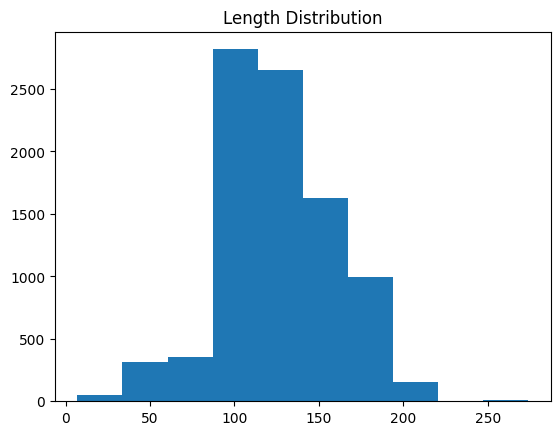

Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

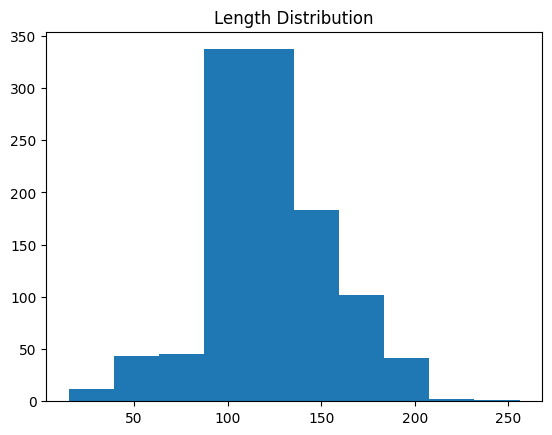

Converting json to dataset:   0%|          | 0/114 [00:00<?, ?it/s]

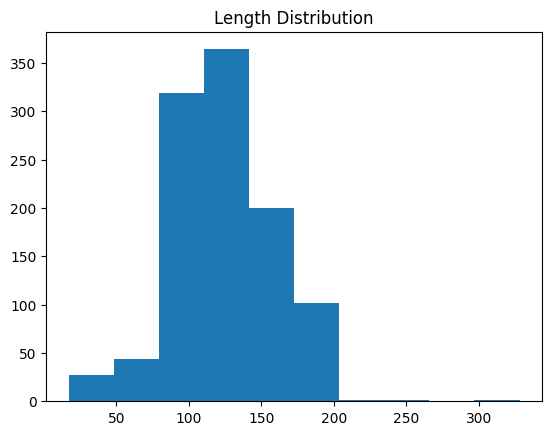

Map:   0%|          | 0/48273 [00:00<?, ? examples/s]

Map:   0%|          | 0/8402 [00:00<?, ? examples/s]

Map:   0%|          | 0/8540 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 48273
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8402
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 8540
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 48273
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 8402
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 8540
    })
})
### Loading Model ###


Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.LayerNorm.bias', 'predictions.bias', 'sop_classifier.classifier.bias', 'sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

### Training Model ###


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.852800,1.075374
2,0.686400,1.111044
3,0.455700,1.233197


### Evaluating Model ###
کتاب مقدس دین اسلام چیست؟
قرآن کتاب مقدس دین اسلام است و در باور مسلمانان سخنان خداست که به صورت وحی از سوی او توسط جبرئیل بر پیامبر اسلام، محمد بن عبدالله، نازل شده‌ است. مسلمانان، قرآن را بزرگترین معجزهٔ محمد و روشن‌ترین دلیل بر پیامبری او می‌دانند. قرآن اصلی‌ترین منبع وحی در اسلام به‌شمار می‌آید و به زبان عربی است. کلمهٔ قرآن در لغت به معنی «قرائت کردن» و «خواندن» است و مسلمانان معمولاً به آن با عناوینی مانند «قرآن کریم» و «قرآن مجید» اشاره می‌کنند. قرآن به ۳۰ جزء تقسیم شده و ۱۱۴ سوره دارد.
{'score': 0.9982663989067078, 'start': 0, 'end': 5, 'answer': 'قرآن'}


<ipython-input-20-dab71847fa9c>:46: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad")  # Load the SQuAD metric


0it [00:00, ?it/s]

{'exact_match': 56.48817345597897, 'f1': 77.83653745721735}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py:259 in                  │
│ hf_raise_for_status                                                                              │
│                                                                                                  │
│   256 │   </Tip>                                                                                 │
│   257 │   """                                                                                    │
│   258 │   try:                                                                                   │
│ ❱ 259 │   │   response.raise_for_status()                                                        │
│   260 │   except HTTPError as e:                                                                 │
│   261 │   │   error_code = response.headers.get("X-Error-Code")                                  │
│   262                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/requests/models.py:960 in raise_for_status               │
│                                                                                                  │
│   957 │   │   │   http_error_msg = u'%s Server Error: %s for url: %s' % (self.status_code, rea   │
│   958 │   │                                                                                      │
│   959 │   │   if http_error_msg:                                                                 │
│ ❱ 960 │   │   │   raise HTTPError(http_error_msg, response=self)                                 │
│   961 │                                                                                          │
│   962 │   def close(self):                                                                       │
│   963 │   │   """Releases the connection back to the pool. Once this method has been             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
HTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 8>:8                                                                              │
│ in push_to_hub:71                                                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:804 in push_to_hub             │
│                                                                                                  │
│    801 │   │   else:                                                                             │
│    802 │   │   │   working_dir = repo_id.split("/")[-1]                                          │
│    803 │   │                                                                                     │
│ ❱  804 │   │   repo_id = self._create_repo(                                                      │
│    805 │   │   │   repo_id, private=private, use_auth_token=use_auth_token, repo_url=repo_url,   │
│    806 │   │   )                                                                                 │
│    807                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:661 in _create_repo            │
│                                                                                                  │


In [ ]:
from transformers import TrainingArguments

model_checkpoint = "m3hrdadfi/albert-fa-base-v2"  # Specify the model checkpoint to use
dataset = DATASETS["pquad"]  # Select the dataset to train on
trainer = TrainerQA(model_checkpoint, dataset)  # Create an instance of the TrainerQA class
trainer.train()  # Train the model using the specified dataset
trainer.evaluate()  # Evaluate the trained model
trainer.push_to_hub("albert-fa-base-v2_pquad")  # Push the trained model to the Hugging Face Model Hub
